In [2]:
%load_ext autoreload
%autoreload 1
%aimport src
%aimport src.utils
%aimport src.SdmIsmAnalysis
%aimport src.SimpleSynthesis

# display last assigned variable automatically
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

%matplotlib inline
from matplotlib.pyplot import *

from src.utils import mygrid

import seaborn as sns
import polars as pl
import numpy as np
import scipy
from pathlib import Path
import os

from sklearn.decomposition import PCA
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels

In [3]:
raw = pl.read_csv("../webMUSHRA-1.4.3/results/listening_test_fried/mushra.csv")

session_test_id,ID,trial_id,rating_stimulus,rating_score,rating_time,rating_comment
str,i64,str,str,i64,i64,str
"""listening_test…",0,"""trial14""","""mid_anchor""",100,7067,null
"""listening_test…",0,"""trial14""","""bad_filtered""",100,7067,null
"""listening_test…",0,"""trial14""","""bad""",100,7067,null
"""listening_test…",0,"""trial14""","""reference""",100,7067,null
"""listening_test…",0,"""trial14""","""lower_anchor""",100,7067,null
…,…,…,…,…,…,…
"""listening_test…",10,"""trial19""","""mid_anchor""",82,67858,null
"""listening_test…",10,"""trial19""","""reference""",100,67858,null
"""listening_test…",10,"""trial19""","""bad_filtered""",65,67858,null


In [4]:
# expected number of rows is 5*20 = 100 per participant, yes!

In [5]:
raw["session_test_id"][0]

'listening_test_fried'

In [6]:
df0 = raw.filter( 
    pl.col("ID") > 0, # filter out test run
    pl.col("trial_id").ne("trial14") & pl.col("trial_id").ne("trial11") # exclude training
).select(
    pl.exclude(["rating_comment", # comment is always null
    "session_test_id"]) # is always 'listening_test_fried'
)

ID,trial_id,rating_stimulus,rating_score,rating_time
i64,str,str,i64,i64
1,"""trial0""","""bad_filtered""",90,82201
1,"""trial0""","""bad""",95,82201
1,"""trial0""","""reference""",100,82201
1,"""trial0""","""lower_anchor""",0,82201
1,"""trial0""","""mid_anchor""",71,82201
…,…,…,…,…
10,"""trial19""","""mid_anchor""",82,67858
10,"""trial19""","""reference""",100,67858
10,"""trial19""","""bad_filtered""",65,67858


In [7]:
5*18*10

900

In [8]:
df0_pivot = df0.pivot(columns="rating_stimulus", values="rating_score", index=["ID", "trial_id", "rating_time"])

ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor
i64,str,i64,i64,i64,i64,i64,i64
1,"""trial0""",82201,90,95,100,0,71
1,"""trial1""",41609,67,0,100,37,83
1,"""trial2""",54521,75,89,100,0,45
1,"""trial3""",46275,86,72,100,49,81
1,"""trial4""",64467,68,50,100,0,82
…,…,…,…,…,…,…,…
10,"""trial15""",30625,65,85,100,31,47
10,"""trial16""",62876,84,69,100,25,75
10,"""trial17""",50133,44,64,100,39,71


In [9]:
df0_pivot.describe()

statistic,ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor
str,f64,str,f64,f64,f64,f64,f64,f64
"""count""",180.0,"""180""",180.0,180.0,180.0,180.0,180.0,180.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",5.5,null,81934.144444,76.205556,58.477778,98.394444,37.672222,75.522222
"""std""",2.880293,null,42194.570977,13.858703,26.491794,6.197402,24.669623,13.852558
"""min""",1.0,"""trial0""",25122.0,27.0,0.0,53.0,0.0,41.0
"""25%""",3.0,null,50602.0,68.0,39.0,100.0,21.0,69.0
"""50%""",6.0,null,70994.0,77.0,66.0,100.0,37.0,77.0
"""75%""",8.0,null,98573.0,86.0,80.0,100.0,53.0,85.0
"""max""",10.0,"""trial9""",272769.0,100.0,100.0,100.0,100.0,100.0


# Exploratory Statistics

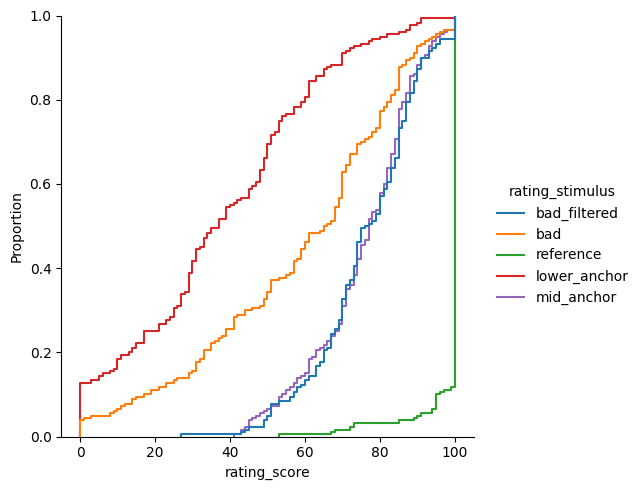

In [79]:
sns.displot(df0, x="rating_score", hue="rating_stimulus", kind="ecdf")

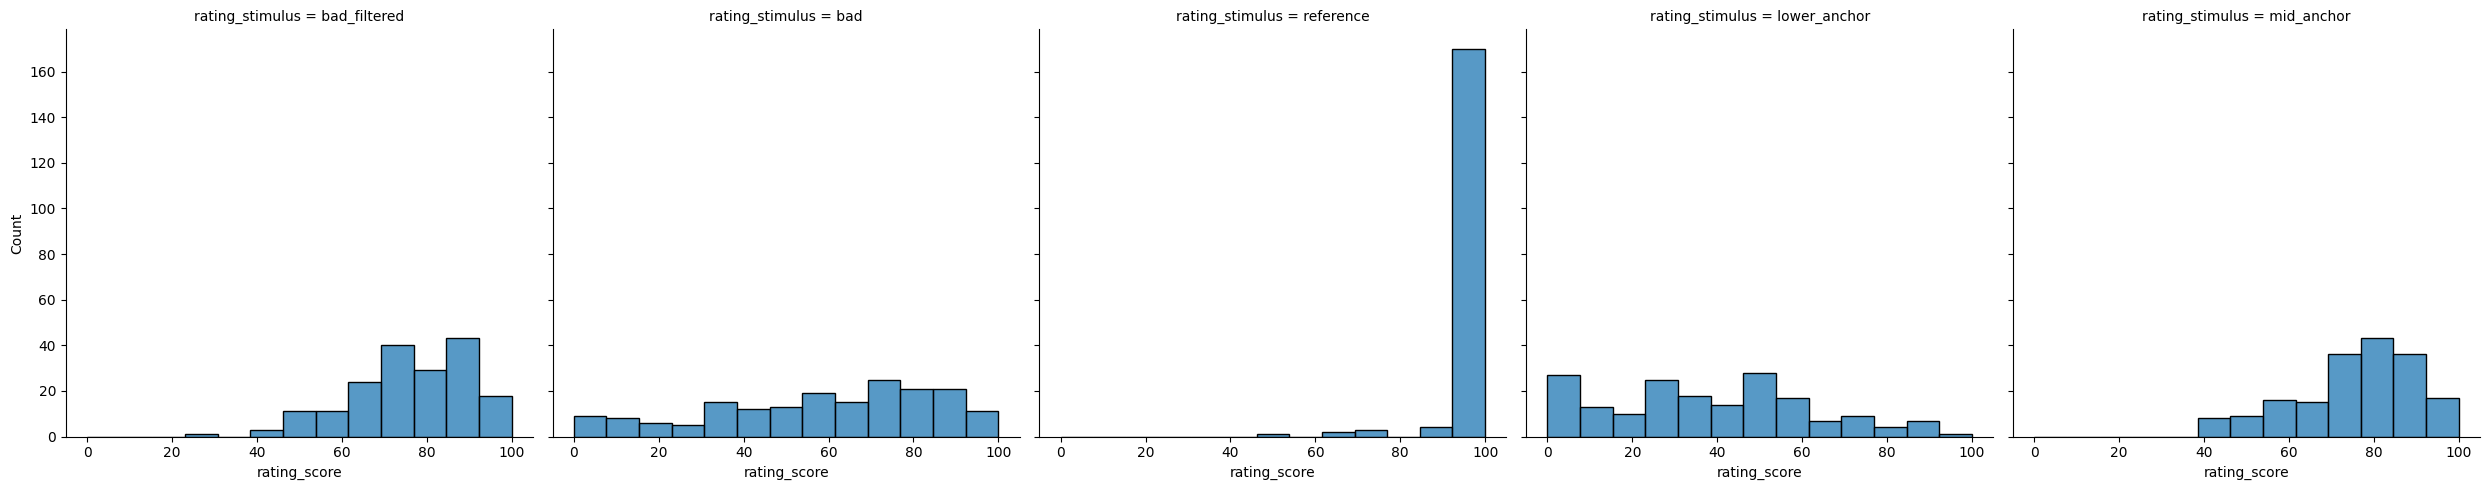

In [80]:
sns.displot(df0, x="rating_score", col="rating_stimulus", kind="hist")

The ratings are distributed according to expectation, great!

No strong bimodality. 

# Unidimensionality

In [83]:
scores_arr = np.stack(
    df0.group_by(
        "trial_id", "rating_stimulus", maintain_order=True
    ).agg(
        "rating_score"
    )["rating_score"].to_numpy()
)

array([[ 90,  91,  90,  87,  81, 100, 100, 100,  67,  70],
       [ 95,  70,  86,  84,  93, 100,  90, 100,  85,  80],
       [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
       [  0,   0,   0,   0,  25,  61,  61,  51,  10,  27],
       [ 71,  78,  77,  46,  72, 100,  90,  83,  69,  70],
       [ 37,  10,  39,  31,  48,  60,  82,  85,  50,  57],
       [  0,  10,  39,  33,  33,  55,  44,  70,  11,  68],
       [ 83,  88,  82,  80,  73,  83,  84,  87,  77,  81],
       [ 67,  83,  88,  72,  71, 100,  86,  85,  85,  94],
       [100, 100, 100, 100, 100, 100, 100, 100, 100,  73],
       [ 89,  82,  89,  91,  81,  88,  90,  85,  85,  83],
       [ 45,  75,  87,  69,  70,  91,  83,  85,  70,  90],
       [ 75,  84,  89,  90,  80,  87,  85,  85,  85,  83],
       [  0,   0,   0,   0,  17,  61,  65,  51,  30,  29],
       [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
       [ 49,  31,  33,  53,  34,  91,  88,  80,  88,  45],
       [100, 100, 100, 100, 100, 100, 100, 100, 100,  67

In [84]:
scores_arr.shape

(90, 10)

In [85]:
pca = PCA().fit(scores_arr.T) # transpose, because each participant is a sample, each score is a feature

PCA()

Text(0.5, 1.0, 'PCA Explained Variance')

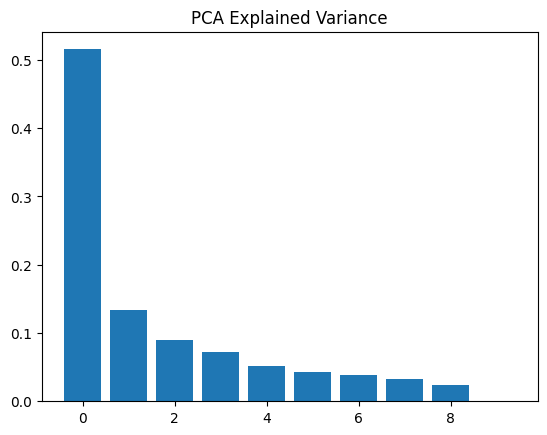

In [89]:
bar(range(10), pca.explained_variance_ratio_)
title("PCA Explained Variance")

In [90]:
np.sum(pca.explained_variance_ratio_)

1.0

In [398]:
pca.explained_variance_ratio_

array([5.15357935e-01, 1.33319121e-01, 8.95055758e-02, 7.15293835e-02,
       5.18615205e-02, 4.27966521e-02, 3.86860233e-02, 3.24871022e-02,
       2.44566866e-02, 3.86014415e-32])

In [92]:
pca.explained_variance_ratio_[0]/pca.explained_variance_ratio_[1]

3.865596554186517

We conclude that the scale is unidimensional since the first PCA dimension explains almost 4 times the variance of the second component. 

# Independence of Observations

Participants didn't meet, instructor left for test phase, order of stimuli wasn't known to participant or instructor

# Homogeneity of variance6

Not needed with rmANOVA

# Outlier Detection

In [10]:
df0_pivot.group_by(
    "ID"
).agg(
    pl.col("reference").filter(pl.col("reference") < 90).count()
)

ID,reference
i64,u32
7,1
5,0
1,0
6,0
4,0
2,0
3,0
10,6
8,1


The cutoff here is 15 %, of 18 trials means

In [11]:
.15*18

2.6999999999999997

ID 10 should be excluded, since the reference was rated below 100 6 out of 18 trials, with the cutoff being 2.7.

In [12]:
df0_pivot.filter(
    pl.col("mid_anchor") > 90
).group_by("ID").count()

C:\Users\jcmfs\AppData\Local\Temp\ipykernel_24372\2464721808.py:3: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).group_by("ID").count()


ID,count
i64,u32
10,4
2,1
9,3
4,2
6,11


This criterion would exclude ID 6, 9, 10, which is 30 %. 

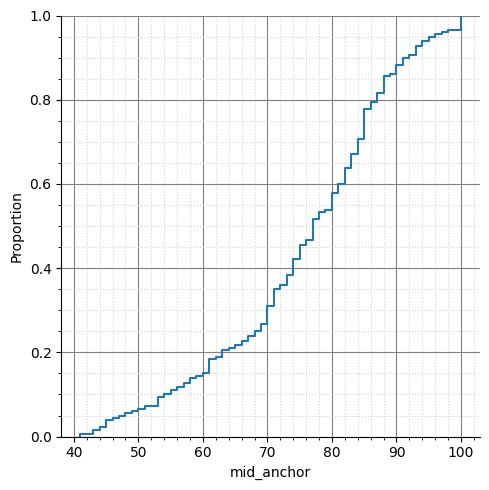

In [13]:
sns.displot(df0_pivot, x="mid_anchor", kind="ecdf")
mygrid()

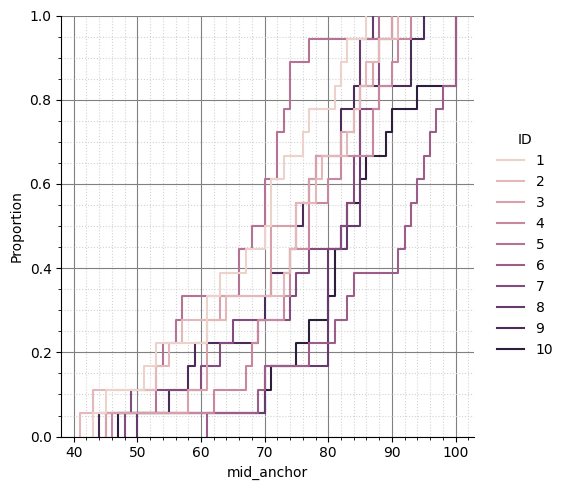

In [14]:
sns.displot(df0_pivot, x="mid_anchor", kind="ecdf", hue="ID")
mygrid()

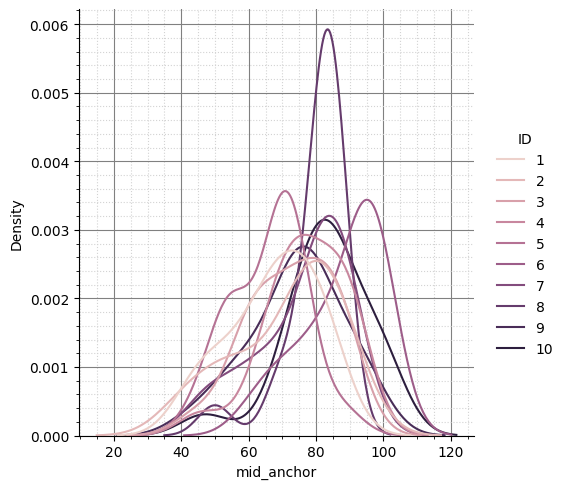

In [15]:
sns.displot(df0_pivot, x="mid_anchor", kind="kde", hue="ID")
mygrid()

In [16]:
df0_pivot.filter(
    pl.col("mid_anchor") > 98
).group_by("ID").count()

C:\Users\jcmfs\AppData\Local\Temp\ipykernel_24372\728375210.py:3: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).group_by("ID").count()


ID,count
i64,u32
6,3
10,3


I'm gonna decide to exclude 6 and 10 based on this criterion, since their ecdf for the mid_anchor is visibly different from the other participants. I will leave 9 in, since the ratings are not visibly differently distributed from the other participants and 3 is rather close to the cutoff of 2.7. 

In [17]:
exclude_ids = [6,10]

[6, 10]

In [18]:
df1 = df0.filter(pl.col("ID").is_in(exclude_ids).not_())

ID,trial_id,rating_stimulus,rating_score,rating_time
i64,str,str,i64,i64
1,"""trial0""","""bad_filtered""",90,82201
1,"""trial0""","""bad""",95,82201
1,"""trial0""","""reference""",100,82201
1,"""trial0""","""lower_anchor""",0,82201
1,"""trial0""","""mid_anchor""",71,82201
…,…,…,…,…
9,"""trial19""","""mid_anchor""",59,158777
9,"""trial19""","""lower_anchor""",90,158777
9,"""trial19""","""bad""",14,158777


In [19]:
df1_pivot = df0_pivot.filter(pl.col("ID").is_in(exclude_ids).not_())

ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor
i64,str,i64,i64,i64,i64,i64,i64
1,"""trial0""",82201,90,95,100,0,71
1,"""trial1""",41609,67,0,100,37,83
1,"""trial2""",54521,75,89,100,0,45
1,"""trial3""",46275,86,72,100,49,81
1,"""trial4""",64467,68,50,100,0,82
…,…,…,…,…,…,…,…
9,"""trial15""",146434,75,21,100,45,75
9,"""trial16""",97336,95,60,100,53,71
9,"""trial17""",81182,78,78,100,59,74


In [20]:
df1_pivot.describe()

statistic,ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor
str,f64,str,f64,f64,f64,f64,f64,f64
"""count""",144.0,"""144""",144.0,144.0,144.0,144.0,144.0,144.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",4.875,null,86515.583333,74.729167,55.083333,99.666667,34.138889,73.069444
"""std""",2.722286,null,44762.219987,13.283998,26.318251,2.609825,24.635698,13.100821
"""min""",1.0,"""trial0""",25122.0,27.0,0.0,73.0,0.0,41.0
"""25%""",3.0,null,51412.0,67.0,36.0,100.0,14.0,65.0
"""50%""",5.0,null,77508.0,75.0,60.0,100.0,32.0,75.0
"""75%""",7.0,null,109054.0,85.0,75.0,100.0,50.0,84.0
"""max""",9.0,"""trial9""",272769.0,100.0,100.0,100.0,90.0,95.0


# Normal distribution of residuals

In [21]:
mod = ols(
    "rating_score ~ C(trial_id) + C(rating_stimulus)",
    df1.with_columns(
        trial_stimulus = pl.concat_str(pl.col("trial_id"), pl.col("rating_stimulus"))
    ).to_pandas()
)

In [441]:
res = mod.fit()

In [442]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rating_score   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     59.17
Date:                Fri, 23 Aug 2024   Prob (F-statistic):          2.27e-139
Time:                        17:08:45   Log-Likelihood:                -3062.5
No. Observations:                 720   AIC:                             6169.
Df Residuals:                     698   BIC:                             6270.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             61.2958      3.022     20.282      0.000      55.362      67.229
C(trial_id)[T.trial1]                 -5.7250      3.866     -1.481      0.139     -13.315       1.865
C(trial_id)[T.trial10]                -5.1750      3.866     -1.339      0.181     -12.765       2.415
C(trial_id)[T.trial12]                -8.9500      3.866     -2.315      0.021     -16.540      -1.360
C(trial_id)[T.trial13]                -4.4250      3.866     -1.145      0.253     -12.015       3.165
C(trial_id)[T.trial15]               -16.6000      3.866     -4.294      0.000     -24.190      -9.010
C(trial_id)[T.trial16]                -5.3750      3.866     -1.390      0.165     -12.965       2.215
C(trial_id)[T.trial17]                -9.0000      3.866     -2.328      0.020     -16.590      -1.410
C(trial_id)[T.trial18]               -16.9000      3.866     -4.372      0.000     -24.490      -9.310
C(trial_id)[T.trial19]               -13.5000      3.866     -3.492      0.001     -21.090      -5.910
C(trial_id)[T.trial2]                 -0.7500      3.866     -0.194      0.846      -8.340       6.840
C(trial_id)[T.trial3]                  6.4250      3.866      1.662      0.097      -1.165      14.015
C(trial_id)[T.trial4]                 -3.5250      3.866     -0.912      0.362     -11.115       4.065
C(trial_id)[T.trial5]                  0.4750      3.866      0.123      0.902      -7.115       8.065
C(trial_id)[T.trial6]                -15.2000      3.866     -3.932      0.000     -22.790      -7.610
C(trial_id)[T.trial7]                 -2.3500      3.866     -0.608      0.543      -9.940       5.240
C(trial_id)[T.trial8]                 -9.2750      3.866     -2.399      0.017     -16.865      -1.685
C(trial_id)[T.trial9]                 -1.9750      3.866     -0.511      0.610      -9.565       5.615
C(rating_stimulus)[T.bad_filtered]    19.6458      2.038      9.642      0.000      15.645      23.646
C(rating_stimulus)[T.lower_anchor]   -20.9444      2.038    -10.279      0.000     -24.945     -16.944
C(rating_stimulus)[T.mid_anchor]      17.9861      2.038      8.827      0.000      13.986      21.987
C(rating_stimulus)[T.reference]       44.5833      2.038     21.881      0.000      40.583      48.584
==============================================================================
Omnibus:                       14.938   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.005
Skew:                          -0.218   Prob(JB):                     4.53e-05
Kurtosis:                       3.690   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume

Both Jarque-Bera as well as Omnibus indicate non-normally distributed residuals. 

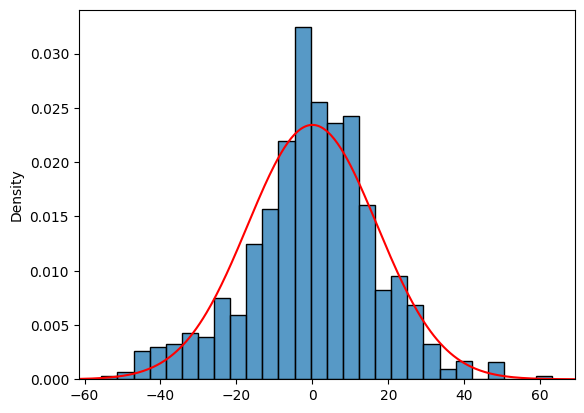

In [443]:
sns.histplot(res.resid, stat="density")
autoscale(False)
xh = np.linspace(*gca().get_xlim(), 300)
plot(xh, scipy.stats.norm.pdf(xh, loc=np.mean(res.resid), scale=np.std(res.resid)), "red")

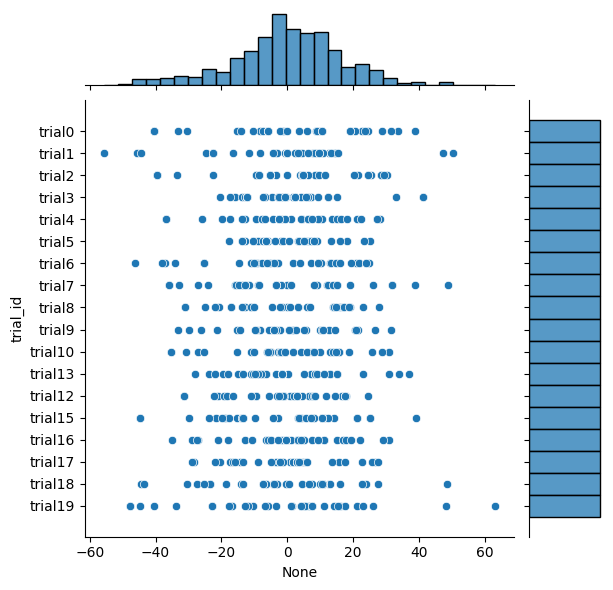

In [449]:
sns.jointplot(x=res.resid, y=df1["trial_id"])

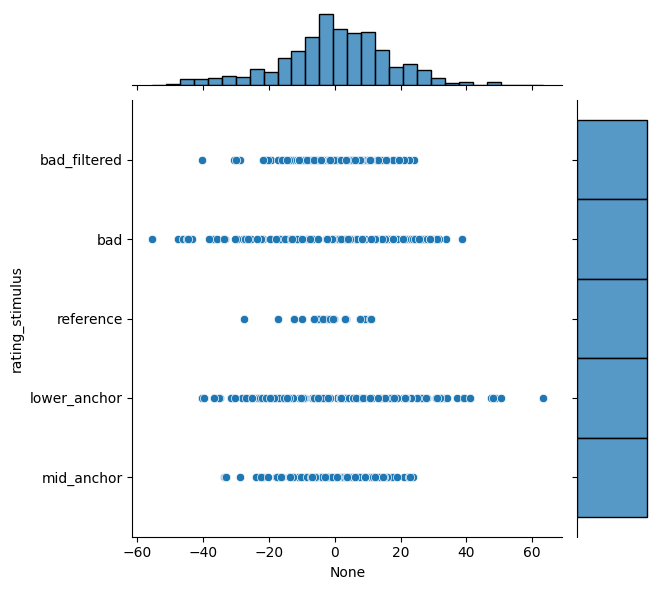

In [450]:
sns.jointplot(x=res.resid, y=df1["rating_stimulus"])

In [453]:
df1.with_columns(
    resid = np.array(res.resid),
).group_by("rating_stimulus").agg(pl.col("resid").std())

rating_stimulus,resid
str,f64
"""bad""",22.980002
"""mid_anchor""",12.239729
"""reference""",6.865981
"""bad_filtered""",11.851123
"""lower_anchor""",24.362241


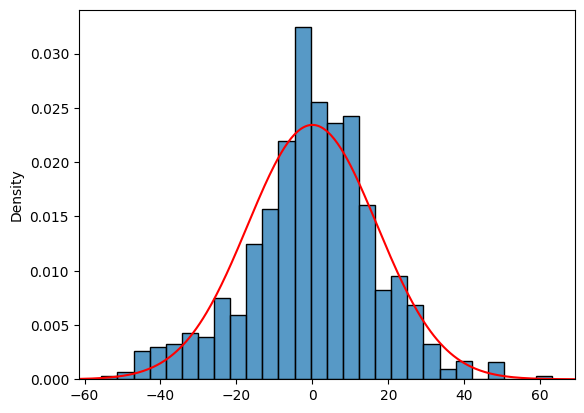

In [443]:
sns.histplot(res.resid, stat="density")
autoscale(False)
xh = np.linspace(*gca().get_xlim(), 300)
plot(xh, scipy.stats.norm.pdf(xh, loc=np.mean(res.resid), scale=np.std(res.resid)), "red")

It's not the biggest deviation ever but noticeable...

# rmANOVA

In [137]:
anovarm = AnovaRM(df1.with_columns(audio=pl.col("trial_id").str.slice(5).str.to_integer() % 2).to_pandas(), "rating_score", "ID", within=["trial_id", "rating_stimulus"]).fit()

In [138]:
anovarm.anova_table

,F Value,Num DF,Den DF,Pr > F
trial_id,10.142858,17.0,119.0,3.705271e-16
rating_stimulus,72.324476,4.0,28.0,2.390200e-14
trial_id:rating_stimulus,10.513589,68.0,476.0,2.542812e-60


In [139]:
anovarm.summary()

,F Value,Num DF,Den DF,Pr > F
trial_id,10.1429,17.0000,119.0000,0.0000
rating_stimulus,72.3245,4.0000,28.0000,0.0000
trial_id:rating_stimulus,10.5136,68.0000,476.0000,0.0000


Okay, both trial and stimulus have a strong effect (?). 

Now I need post-hoc tests. Let's go for Tukey's HSD, though I don't know how that works.

## Post-hoc: Stimulus Differences

In [679]:
hsd = pairwise_tukeyhsd(df1["rating_score"], df1["rating_stimulus"])

In [680]:
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
bad,bad_filtered,19.6458,0.0,13.7831,25.5085,True
bad,lower_anchor,-20.9444,0.0,-26.8071,-15.0818,True
bad,mid_anchor,17.9861,0.0,12.1234,23.8488,True
bad,reference,44.5833,0.0,38.7206,50.446,True
bad_filtered,lower_anchor,-40.5903,0.0,-46.453,-34.7276,True
bad_filtered,mid_anchor,-1.6597,0.938,-7.5224,4.203,False
bad_filtered,reference,24.9375,0.0,19.0748,30.8002,True
lower_anchor,mid_anchor,38.9306,0.0,33.0679,44.7932,True
lower_anchor,reference,65.5278,0.0,59.6651,71.3905,True
mid_anchor,reference,26.5972,0.0,20.7345,32.4599,True


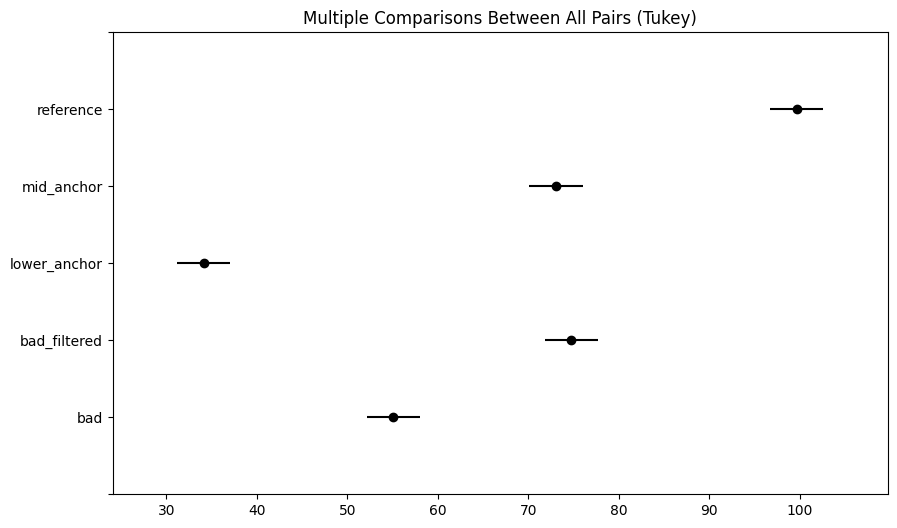

In [681]:
hsd.plot_simultaneous();

In [683]:
hsd.halfwidths

array([2.93134362, 2.93134362, 2.93134362, 2.93134362, 2.93134362])

Okay, these are pretty good :). All rating stimuli are significantly different from each other, except for mid_anchor and bad_filtered. 

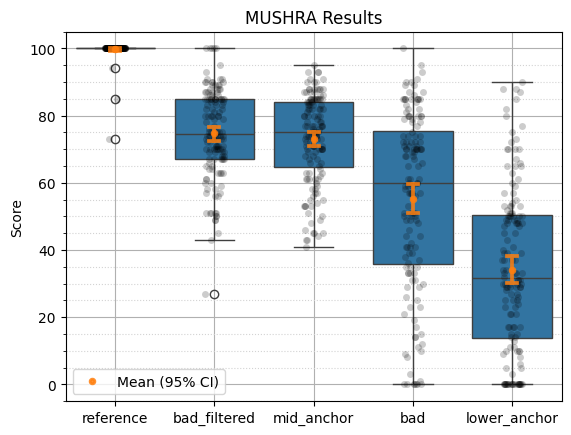

In [694]:
sns.boxplot(df1, y = "rating_score", x = "rating_stimulus", order=["reference", "bad_filtered", "mid_anchor", "bad", "lower_anchor"])
sns.stripplot(df1, y = "rating_score", x = "rating_stimulus", color="black", alpha=.2)
sns.pointplot(df1, y = "rating_score", x = "rating_stimulus", color="C1", zorder=10, alpha=.85, 
              linestyle="none", marker=".", capsize=.1, label="Mean (95% CI)")
ylabel("Score")
xlabel("")
title("MUSHRA Results")
grid(True, which="major")
grid(True, which="minor", color="lightgrey", linestyle=":", axis="y")
minorticks_on()
tick_params(axis='x', which='minor', bottom=False)
savefig("../reports/figures/mushra_main_result.pdf")

In [478]:
df1_pivot.filter(
    pl.col("bad_filtered") < pl.col("bad")
).count()

ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor
u32,u32,u32,u32,u32,u32,u32,u32
27,27,27,27,27,27,27,27


In [479]:
df1_pivot.count()

ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor
u32,u32,u32,u32,u32,u32,u32,u32
144,144,144,144,144,144,144,144


In [481]:
(144 - 27)/144

0.8125

### separated by room

In [22]:
df1_join = df1.with_columns(
    trial = pl.col("trial_id").str.slice(5).str.to_integer().cast(pl.datatypes.UInt32)
).join(design, left_on="trial", right_on="index")

NameError: name 'design' is not defined

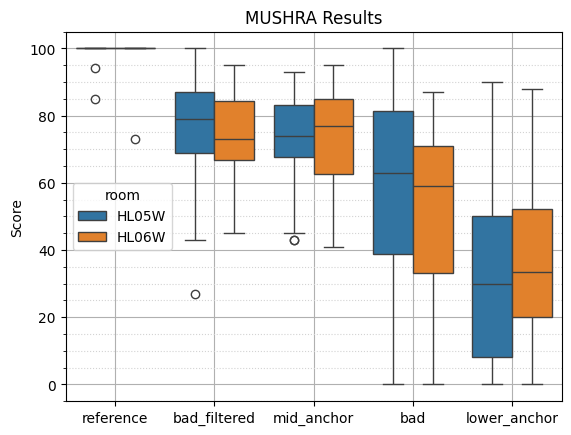

In [622]:
sns.boxplot(df1_join, y = "rating_score", x = "rating_stimulus", hue="room", order=["reference", "bad_filtered", "mid_anchor", "bad", "lower_anchor"])
#sns.stripplot(df1, y = "rating_score", x = "rating_stimulus", color="black", alpha=.2)
ylabel("Score")
xlabel("")
title("MUSHRA Results")
savefig("../reports/figures/mushra_main_result.pdf")
grid(True, which="major")
grid(True, which="minor", color="lightgrey", linestyle=":", axis="y")
minorticks_on()
tick_params(axis='x', which='minor', bottom=False)

### separated by trial

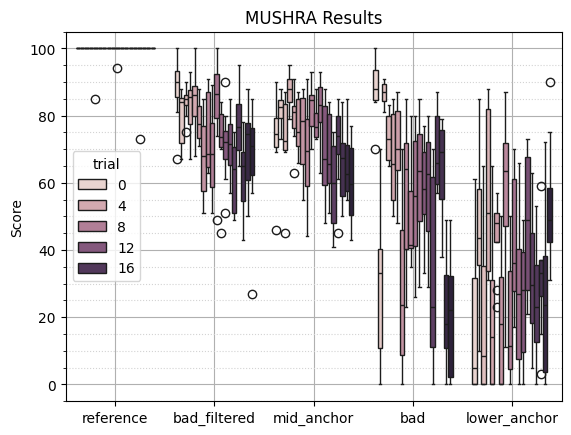

In [623]:
sns.boxplot(df1_join, y = "rating_score", x = "rating_stimulus", hue="trial", order=["reference", "bad_filtered", "mid_anchor", "bad", "lower_anchor"])
#sns.stripplot(df1, y = "rating_score", x = "rating_stimulus", color="black", alpha=.2)
ylabel("Score")
xlabel("")
title("MUSHRA Results")
savefig("../reports/figures/mushra_main_result.pdf")
grid(True, which="major")
grid(True, which="minor", color="lightgrey", linestyle=":", axis="y")
minorticks_on()
tick_params(axis='x', which='minor', bottom=False)

## Post-hoc: Trial Differences

In [33]:
df_trial = df1.with_columns(
    pl.col("trial_id").str.slice(5).str.to_integer().cast(pl.datatypes.UInt32).alias("trial")
)
df_trial = df_trial.with_columns(
    exp_idx = np.argmax(np.tile(df_trial["trial"].to_numpy(), (18,1)).T == np.tile(np.array(trials_exp_order[2:]), (720, 1)), axis=1)
)
hsd = pairwise_tukeyhsd(df1["rating_score"], df_trial["trial"])

In [752]:
hsd.df_total

702

In [753]:
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-5.725,1.0,-27.6843,16.2343,False
0,2,-0.75,1.0,-22.7093,21.2093,False
0,3,6.425,0.9999,-15.5343,28.3843,False
0,4,-3.525,1.0,-25.4843,18.4343,False
0,5,0.475,1.0,-21.4843,22.4343,False
0,6,-15.2,0.5898,-37.1593,6.7593,False
0,7,-2.35,1.0,-24.3093,19.6093,False
0,8,-9.275,0.9919,-31.2343,12.6843,False
0,9,-1.975,1.0,-23.9343,19.9843,False
0,10,-5.175,1.0,-27.1343,16.7843,False


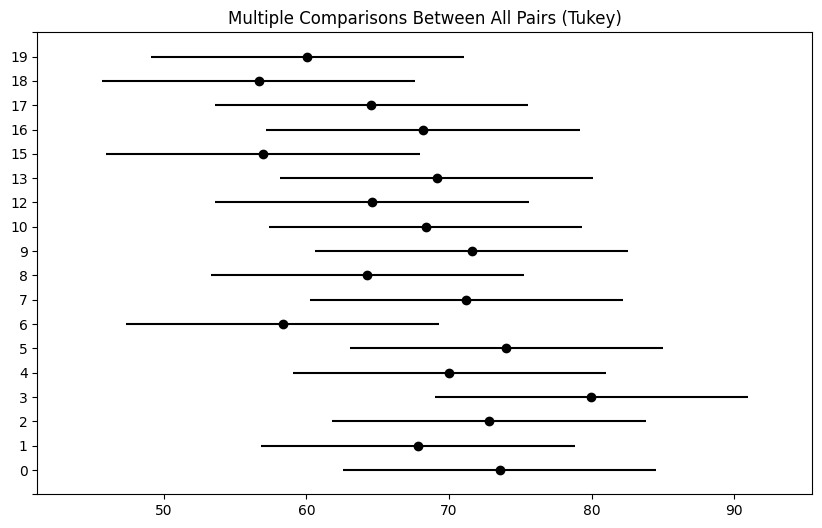

In [754]:
hsd.plot_simultaneous();

Okay, so most trials are actually not different in the mean, except for trial3 (highest ratings), which is significantly different from trial18 and trail15 (lowest ratings). 

However, you should note that there is a clear training effect: Later trials are rated more different. 

In [35]:
df_trial

ID,trial_id,rating_stimulus,rating_score,rating_time,trial,exp_idx
i64,str,str,i64,i64,u32,i64
1,"""trial0""","""bad_filtered""",90,82201,0,0
1,"""trial0""","""bad""",95,82201,0,0
1,"""trial0""","""reference""",100,82201,0,0
1,"""trial0""","""lower_anchor""",0,82201,0,0
1,"""trial0""","""mid_anchor""",71,82201,0,0
…,…,…,…,…,…,…
9,"""trial19""","""mid_anchor""",59,158777,19,17
9,"""trial19""","""lower_anchor""",90,158777,19,17
9,"""trial19""","""bad""",14,158777,19,17


In [39]:
design

index,to_listener,to_source,room,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32
0,"""0.0X_0.0Y""",1,"""HL05W""","""3.0X_2.0Y""",1
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3
2,"""1.75X_-2.0Y""",2,"""HL05W""","""3.0X_2.0Y""",1
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",3
4,"""1.75X_-2.0Y""",1,"""HL05W""","""3.0X_2.0Y""",3
…,…,…,…,…,…
15,"""-1.25X_0.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4
16,"""1.75X_-2.0Y""",2,"""HL06W""","""0.0X_0.0Y""",4
17,"""3.0X_2.0Y""",3,"""HL05W""","""1.75X_-2.0Y""",4


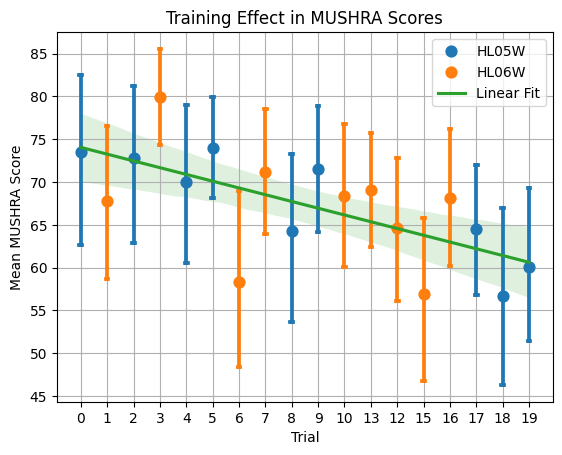

In [47]:
sns.pointplot( df_trial.join(
    design, left_on="trial", right_on="index"
), x="trial", y="rating_score", hue="room", linestyle="none", capsize=.1, order=trials_exp_order[2:])
sns.regplot( df_trial, x="exp_idx", y="rating_score", scatter=False, label="Linear Fit", color="C2")
ylabel("Mean MUSHRA Score")
xlabel("Trial")
title("Training Effect in MUSHRA Scores")
legend()
grid(True)
savefig("../reports/figures/training_effect_mushra.pdf")

## Post-hoc: Trial Differences

In [189]:
#hsd = pairwise_tukeyhsd(df1["rating_score"], df1.select(pl.concat_str(["trial_id", "rating_stimulus"])).to_numpy().squeeze())

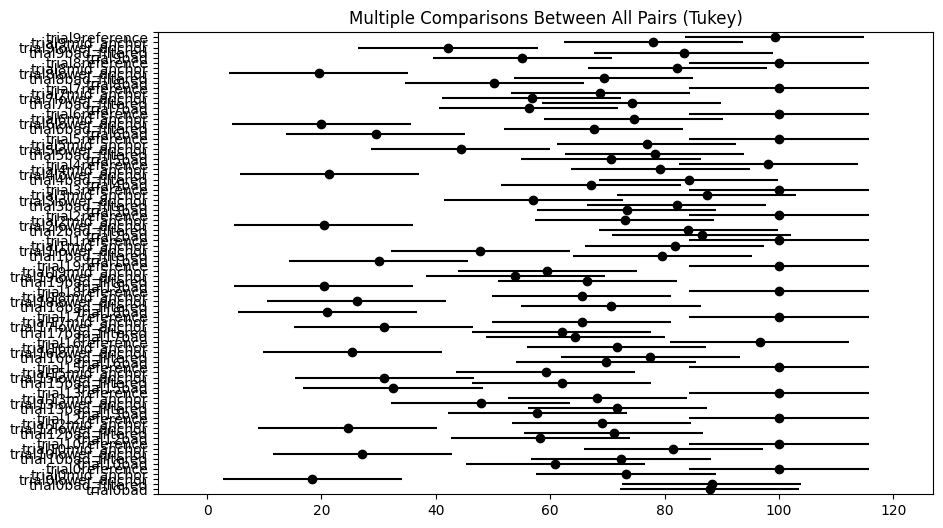

In [190]:
hsd.plot_simultaneous();

I'm not sure how useful this is...

It might be better to look at just bad_filtered and mid_anchor:

In [260]:
df1_filt_mid = df1.filter(
    pl.col("rating_stimulus").is_in(["bad_filtered", "mid_anchor"])
)
hsd = pairwise_tukeyhsd(df1_filt_mid["rating_score"], df1_filt_mid.select(pl.concat_str(["trial_id", "rating_stimulus"])).to_numpy().squeeze())

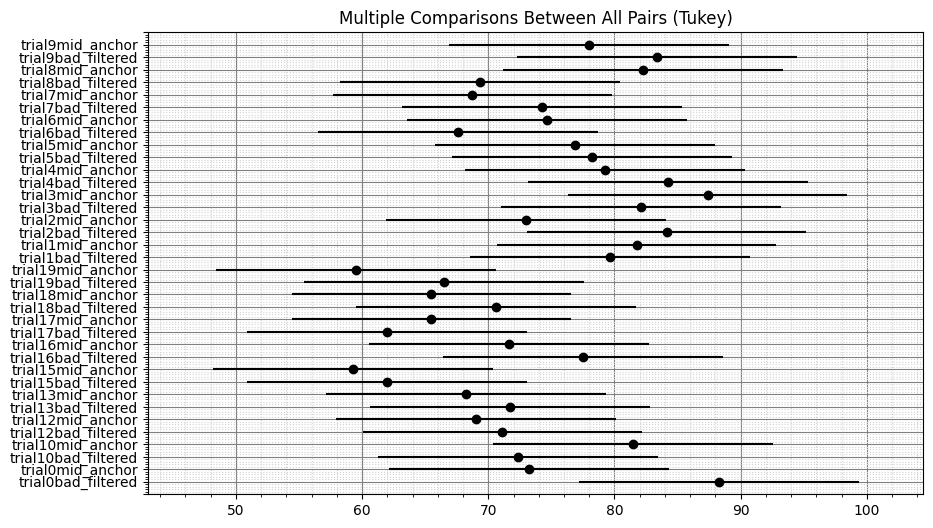

In [263]:
hsd.plot_simultaneous();
mygrid()

Hm, we see here no statistically significant difference between bad_filtered and mid_anchor in the same trial. Let's see how close it is:

In [266]:
s = hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
trial0bad_filtered,trial0mid_anchor,-15.0,0.7675,-37.177,7.177,False
trial0bad_filtered,trial10bad_filtered,-15.875,0.6521,-38.052,6.302,False
trial0bad_filtered,trial10mid_anchor,-6.75,1.0,-28.927,15.427,False
trial0bad_filtered,trial12bad_filtered,-17.125,0.4737,-39.302,5.052,False
trial0bad_filtered,trial12mid_anchor,-19.25,0.2188,-41.427,2.927,False
trial0bad_filtered,trial13bad_filtered,-16.5,0.5629,-38.677,5.677,False
trial0bad_filtered,trial13mid_anchor,-20.0,0.1563,-42.177,2.177,False
trial0bad_filtered,trial15bad_filtered,-26.25,0.0035,-48.427,-4.073,True
trial0bad_filtered,trial15mid_anchor,-29.0,0.0004,-51.177,-6.823,True
trial0bad_filtered,trial16bad_filtered,-10.75,0.9963,-32.927,11.427,False


In [289]:
df_s = pl.read_csv(
    bytes(s.as_csv(), "utf-8"), encoding="utf-8", skip_rows=1
).rename(
    str.strip
).with_columns(
    trial1 = pl.col("group1").str.extract("trial(\d+)"),
    trial2 = pl.col("group2").str.extract("trial(\d+)"),
    stimulus1 = pl.col("group1").str.extract("trial\d+(.*)"),
    stimulus2 = pl.col("group2").str.extract("trial\d+(.*)"),
)

group1,group2,meandiff,p-adj,lower,upper,reject,trial1,trial2,stimulus1,stimulus2
str,str,str,str,str,str,str,str,str,str,str
"""trial0bad_filt…","""trial0mid_anch…","""-15.0 ""","""0.7675""","""-37.177""","""7.177 ""","""False ""","""0""","""0""","""bad_filtered ""","""mid_anchor """
"""trial0bad_filt…","""trial10bad_fil…","""-15.875 ""","""0.6521""","""-38.052""","""6.302 ""","""False ""","""0""","""10""","""bad_filtered ""","""bad_filtered"""
"""trial0bad_filt…","""trial10mid_anc…","""-6.75 ""","""1.0 ""","""-28.927""","""15.427""","""False ""","""0""","""10""","""bad_filtered ""","""mid_anchor """
"""trial0bad_filt…","""trial12bad_fil…","""-17.125 ""","""0.4737""","""-39.302""","""5.052 ""","""False ""","""0""","""12""","""bad_filtered ""","""bad_filtered"""
"""trial0bad_filt…","""trial12mid_anc…","""-19.25 ""","""0.2188""","""-41.427""","""2.927 ""","""False ""","""0""","""12""","""bad_filtered ""","""mid_anchor """
…,…,…,…,…,…,…,…,…,…,…
"""trial8bad_filt…","""trial9bad_filt…","""14.0 ""","""0.8732""","""-8.177 ""","""36.177""","""False ""","""8""","""9""","""bad_filtered ""","""bad_filtered """
"""trial8bad_filt…","""trial9mid_anch…","""8.625 ""","""0.9999""","""-13.552""","""30.802""","""False ""","""8""","""9""","""bad_filtered ""","""mid_anchor """
"""trial8mid_anch…","""trial9bad_filt…","""1.125 ""","""1.0 ""","""-21.052""","""23.302""","""False ""","""8""","""9""","""mid_anchor ""","""bad_filtered """


In [290]:
with pl.Config(set_tbl_rows=1000):
    display(df_s.sort("p-adj").filter(pl.col("trial1") == pl.col("trial2")))

group1,group2,meandiff,p-adj,lower,upper,reject,trial1,trial2,stimulus1,stimulus2
str,str,str,str,str,str,str,str,str,str,str
"""trial0bad_filt…","""trial0mid_anch…","""-15.0 ""","""0.7675""","""-37.177""","""7.177 ""","""False ""","""0""","""0""","""bad_filtered ""","""mid_anchor """
"""trial8bad_filt…","""trial8mid_anch…","""12.875 ""","""0.9491""","""-9.302 ""","""35.052""","""False ""","""8""","""8""","""bad_filtered ""","""mid_anchor """
"""trial2bad_filt…","""trial2mid_anch…","""-11.125 ""","""0.9935""","""-33.302""","""11.052""","""False ""","""2""","""2""","""bad_filtered ""","""mid_anchor """
"""trial10bad_fil…","""trial10mid_anc…","""9.125 ""","""0.9998""","""-13.052""","""31.302""","""False ""","""10""","""10""","""bad_filtered""","""mid_anchor """
"""trial12bad_fil…","""trial12mid_anc…","""-2.125 ""","""1.0 ""","""-24.302""","""20.052""","""False ""","""12""","""12""","""bad_filtered""","""mid_anchor """
"""trial13bad_fil…","""trial13mid_anc…","""-3.5 ""","""1.0 ""","""-25.677""","""18.677""","""False ""","""13""","""13""","""bad_filtered""","""mid_anchor """
"""trial15bad_fil…","""trial15mid_anc…","""-2.75 ""","""1.0 ""","""-24.927""","""19.427""","""False ""","""15""","""15""","""bad_filtered""","""mid_anchor """
"""trial16bad_fil…","""trial16mid_anc…","""-5.875 ""","""1.0 ""","""-28.052""","""16.302""","""False ""","""16""","""16""","""bad_filtered""","""mid_anchor """
"""trial17bad_fil…","""trial17mid_anc…","""3.5 ""","""1.0 ""","""-18.677""","""25.677""","""False ""","""17""","""17""","""bad_filtered""","""mid_anchor """


Yeah, even when comparing single trials, there is no statistically significant difference between bad_filtered and mid_anchor. This can be corrobarated with in the next section. 

Before that, let's group by these two stimuli and room:

In [664]:
df1_filt_mid_design = df1_filt_mid.with_columns(
    pl.col("trial_id").str.slice(5).str.to_integer().cast(pl.datatypes.UInt32).alias("index")
).join(design, "index")

ID,trial_id,rating_stimulus,rating_score,rating_time,index,to_listener,to_source,room,from_listener_bad,from_source_bad
i64,str,str,i64,i64,u32,str,i32,str,str,i32
1,"""trial0""","""bad_filtered""",90,82201,0,"""0.0X_0.0Y""",1,"""HL05W""","""3.0X_2.0Y""",1
1,"""trial0""","""mid_anchor""",71,82201,0,"""0.0X_0.0Y""",1,"""HL05W""","""3.0X_2.0Y""",1
1,"""trial1""","""mid_anchor""",83,41609,1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3
1,"""trial1""","""bad_filtered""",67,41609,1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3
1,"""trial2""","""mid_anchor""",45,54521,2,"""1.75X_-2.0Y""",2,"""HL05W""","""3.0X_2.0Y""",1
…,…,…,…,…,…,…,…,…,…,…
9,"""trial17""","""mid_anchor""",74,81182,17,"""3.0X_2.0Y""",3,"""HL05W""","""1.75X_-2.0Y""",4
9,"""trial18""","""bad_filtered""",60,201423,18,"""-1.25X_0.0Y""",4,"""HL05W""","""3.0X_2.0Y""",3
9,"""trial18""","""mid_anchor""",55,201423,18,"""-1.25X_0.0Y""",4,"""HL05W""","""3.0X_2.0Y""",3


In [665]:
hsd = pairwise_tukeyhsd(df1_filt_mid_design["rating_score"], 
                        df1_filt_mid_design.select(pl.concat_str(["room", "rating_stimulus"])).to_numpy().squeeze())

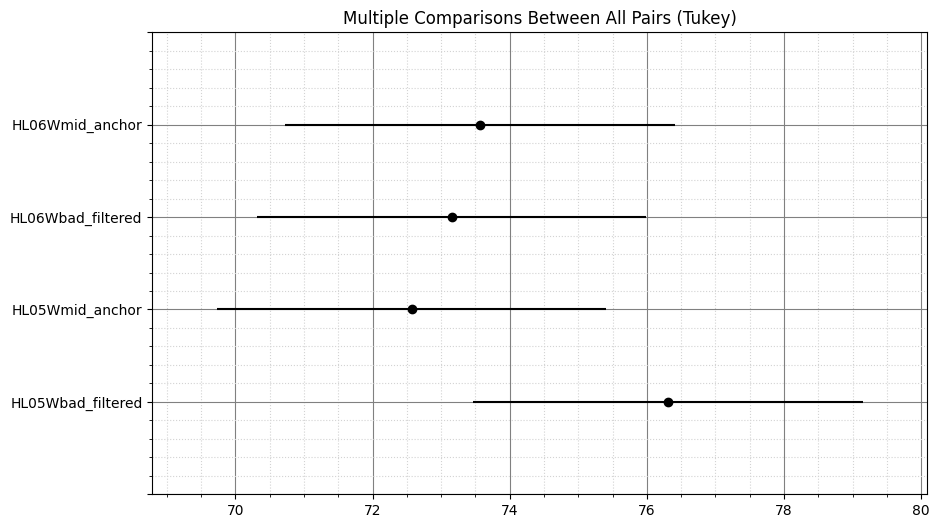

In [666]:
hsd.plot_simultaneous();
mygrid()

In [667]:
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
HL05Wbad_filtered,HL05Wmid_anchor,-3.7361,0.3256,-9.4158,1.9436,False
HL05Wbad_filtered,HL06Wbad_filtered,-3.1528,0.4789,-8.8325,2.5269,False
HL05Wbad_filtered,HL06Wmid_anchor,-2.7361,0.5988,-8.4158,2.9436,False
HL05Wmid_anchor,HL06Wbad_filtered,0.5833,0.9934,-5.0964,6.263,False
HL05Wmid_anchor,HL06Wmid_anchor,1.0,0.9686,-4.6797,6.6797,False
HL06Wbad_filtered,HL06Wmid_anchor,0.4167,0.9976,-5.263,6.0964,False


# Difference bad_filtered to mid_anchor

Let's see whether bad_filtered and mid_anchor are really always this close in each individual case:

In [239]:
df1_pivot_1 = df1_pivot.with_columns(
    delta_filt = pl.col("bad_filtered") - pl.col("mid_anchor"),
    trial = pl.col("trial_id").str.slice(5).str.to_integer().cast(pl.datatypes.UInt32)
)

ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor,delta_filt,trial
i64,str,i64,i64,i64,i64,i64,i64,i64,u32
1,"""trial0""",82201,90,95,100,0,71,19,0
1,"""trial1""",41609,67,0,100,37,83,-16,1
1,"""trial2""",54521,75,89,100,0,45,30,2
1,"""trial3""",46275,86,72,100,49,81,5,3
1,"""trial4""",64467,68,50,100,0,82,-14,4
…,…,…,…,…,…,…,…,…,…
9,"""trial15""",146434,75,21,100,45,75,0,15
9,"""trial16""",97336,95,60,100,53,71,24,16
9,"""trial17""",81182,78,78,100,59,74,4,17


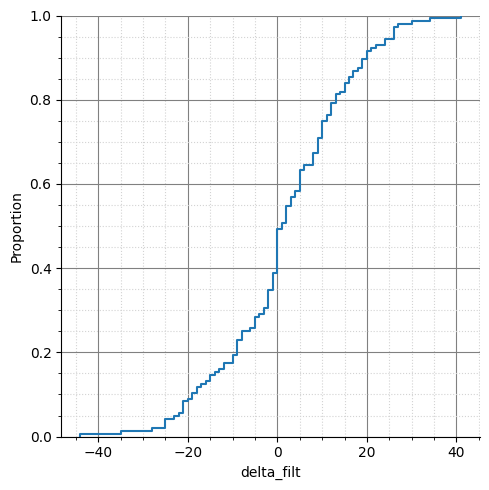

In [240]:
sns.displot(df1_pivot_1, kind="ecdf", x="delta_filt")
mygrid()

Yes, they really are rated just the same in the median. 

In [231]:
df1_pivot_1.describe()

statistic,ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor,delta_filt,trial
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",144.0,"""144""",144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",4.875,null,86515.583333,74.729167,55.083333,99.666667,34.138889,73.069444,1.659722,9.166667
"""std""",2.722286,null,44762.219987,13.283998,26.318251,2.609825,24.635698,13.100821,14.350343,5.985998
"""min""",1.0,"""trial0""",25122.0,27.0,0.0,73.0,0.0,41.0,-44.0,0.0
"""25%""",3.0,null,51412.0,67.0,36.0,100.0,14.0,65.0,-6.0,4.0
"""50%""",5.0,null,77508.0,75.0,60.0,100.0,32.0,75.0,1.0,9.0
"""75%""",7.0,null,109054.0,85.0,75.0,100.0,50.0,84.0,10.0,15.0
"""max""",9.0,"""trial9""",272769.0,100.0,100.0,100.0,90.0,95.0,41.0,19.0


And in the mean...

There really is no rating difference between them. 

Let's group by trial:

In [629]:
g = df1_pivot_1.group_by("trial_id", maintain_order=True).agg(pl.col("delta_filt", "mid_anchor").mean())

trial_id,delta_filt,mid_anchor
str,f64,f64
"""trial0""",15.0,73.25
"""trial1""",-2.125,81.75
"""trial2""",11.125,73.0
"""trial3""",-5.25,87.375
"""trial4""",5.0,79.25
…,…,…
"""trial15""",2.75,59.25
"""trial16""",5.875,71.625
"""trial17""",-3.5,65.5


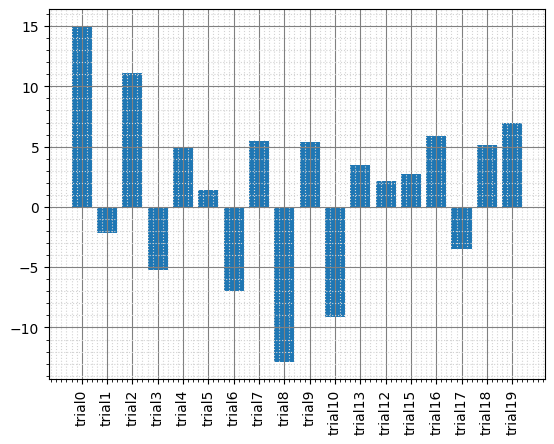

In [630]:
bar(g["trial_id"], g["delta_filt"])
xticks(rotation=90)
mygrid()

In [631]:
g2 = df1_pivot_1.group_by("ID").agg(pl.col("delta_filt").mean())

ID,delta_filt
i64,f64
8,1.888889
9,3.944444
7,5.111111
1,-3.333333
2,1.555556
4,-0.611111
5,3.777778
3,0.944444


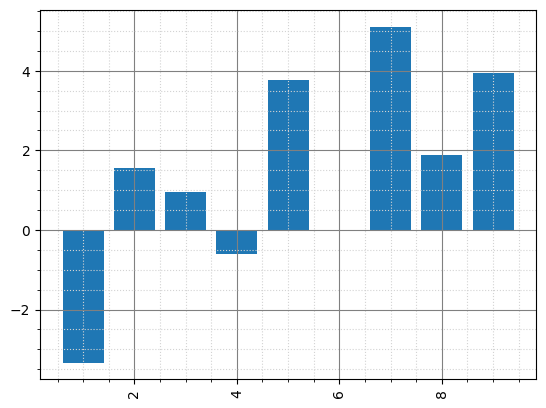

In [632]:
bar(g2["ID"], g2["delta_filt"])
xticks(rotation=90)
mygrid()

At an std of 14, this isn't significant. 

## Bad_Filtered vs Mid_Anchor with room separation

In [38]:
design = pl.read_parquet("listening_test_design.parquet").select(["index", "to_listener", "to_source", "room", "from_listener_bad", "from_source_bad"])

index,to_listener,to_source,room,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32
0,"""0.0X_0.0Y""",1,"""HL05W""","""3.0X_2.0Y""",1
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3
2,"""1.75X_-2.0Y""",2,"""HL05W""","""3.0X_2.0Y""",1
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",3
4,"""1.75X_-2.0Y""",1,"""HL05W""","""3.0X_2.0Y""",3
…,…,…,…,…,…
15,"""-1.25X_0.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4
16,"""1.75X_-2.0Y""",2,"""HL06W""","""0.0X_0.0Y""",4
17,"""3.0X_2.0Y""",3,"""HL05W""","""1.75X_-2.0Y""",4


In [245]:
df1_pivot_2 = df1_pivot_1.join(design, left_on="trial", right_on="index")

ID,trial_id,rating_time,bad_filtered,bad,reference,lower_anchor,mid_anchor,delta_filt,trial,to_listener,to_source,room,from_listener_bad,from_source_bad
i64,str,i64,i64,i64,i64,i64,i64,i64,u32,str,i32,str,str,i32
1,"""trial0""",82201,90,95,100,0,71,19,0,"""0.0X_0.0Y""",1,"""HL05W""","""3.0X_2.0Y""",1
1,"""trial1""",41609,67,0,100,37,83,-16,1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3
1,"""trial2""",54521,75,89,100,0,45,30,2,"""1.75X_-2.0Y""",2,"""HL05W""","""3.0X_2.0Y""",1
1,"""trial3""",46275,86,72,100,49,81,5,3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",3
1,"""trial4""",64467,68,50,100,0,82,-14,4,"""1.75X_-2.0Y""",1,"""HL05W""","""3.0X_2.0Y""",3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9,"""trial15""",146434,75,21,100,45,75,0,15,"""-1.25X_0.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4
9,"""trial16""",97336,95,60,100,53,71,24,16,"""1.75X_-2.0Y""",2,"""HL06W""","""0.0X_0.0Y""",4
9,"""trial17""",81182,78,78,100,59,74,4,17,"""3.0X_2.0Y""",3,"""HL05W""","""1.75X_-2.0Y""",4


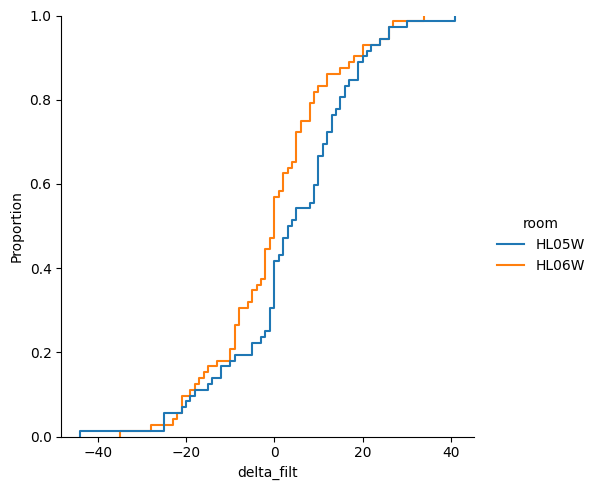

In [247]:
sns.displot(df1_pivot_2, x="delta_filt", hue="room", kind="ecdf")

In [249]:
df1_pivot_2.group_by("room").agg(pl.col("delta_filt").mean())

room,delta_filt
str,f64
"""HL06W""",-0.416667
"""HL05W""",3.736111


There is a difference in the expected direction, but not strong enough I think. It really seems to be more the individual case that is the problem. 

# Trials vs delta_filt

TODO Analyze specific cases where the extrapolation worked much better vs much worse than mid_anchor. Which cases are those? Is it significant?

TODO pull in Likert data, anything of note?

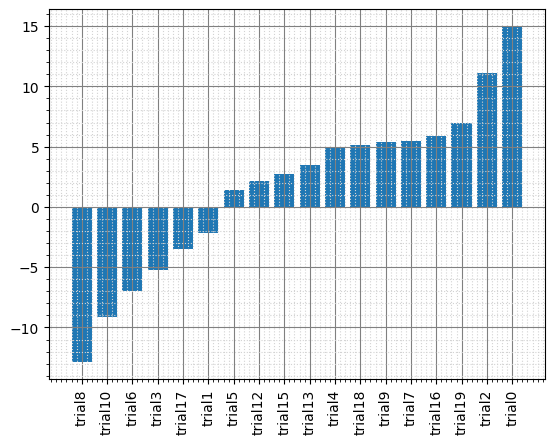

In [626]:
bar(g["trial_id"], g["delta_filt"])
xticks(rotation=90)
mygrid()

In [651]:
g = df1_pivot_2.group_by(
    "trial_id", maintain_order=True
).agg(
    pl.col("delta_filt", "mid_anchor", "bad", "bad_filtered", "lower_anchor").mean()
).with_columns(
    trial = pl.col("trial_id").str.slice(5).str.to_integer().cast(pl.datatypes.UInt32)
).join(
    design, left_on="trial", right_on="index"
).sort(
    "delta_filt"
)
with pl.Config(set_tbl_rows=100):
    display(g)

trial_id,delta_filt,mid_anchor,bad,bad_filtered,lower_anchor,trial,to_listener,to_source,room,from_listener_bad,from_source_bad
str,f64,f64,f64,f64,f64,u32,str,i32,str,str,i32
"""trial8""",-12.875,82.25,50.25,69.375,19.5,8,"""-1.75X_-3.0Y""",4,"""HL05W""","""0.0X_0.0Y""",3
"""trial10""",-9.125,81.5,60.875,72.375,27.125,10,"""3.0X_2.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4
"""trial6""",-7.0,74.625,29.5,67.625,20.0,6,"""-1.75X_-3.0Y""",4,"""HL06W""","""0.0X_0.0Y""",2
"""trial3""",-5.25,87.375,73.375,82.125,57.0,3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",3
"""trial17""",-3.5,65.5,64.375,62.0,30.875,17,"""3.0X_2.0Y""",3,"""HL05W""","""1.75X_-2.0Y""",4
"""trial1""",-2.125,81.75,30.0,79.625,47.75,1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3
"""trial5""",1.375,76.875,70.625,78.25,44.375,5,"""3.0X_2.0Y""",1,"""HL05W""","""3.0X_2.0Y""",3
"""trial12""",2.125,69.0,58.25,71.125,24.625,12,"""-1.25X_0.0Y""",4,"""HL06W""","""1.75X_-2.0Y""",3
"""trial15""",2.75,59.25,32.5,62.0,31.0,15,"""-1.25X_0.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4


Comments on "bad" trials:
- 8: going from middle into corner, particularly bad timbre_dynamics rating (wall->middle to wall->corner). Listening to it, I'm not sure that I would rate mid_anchor much worse than bad_filtered, they are different but not very differently different from reference, I think.
- 10: going from one speaker one the other side of the room to another, behind corner, problems are likely w/ algorithm (wall->wall to wall->wall), listening I hear large geometry error between bad_filtered and mid_anchor, with bad_filtered more to the left, not sure why. **TODO interesting case**
- 6: from corner->middle to side->corner, particularly bad timbre_dynamics rating (corner->middle to wall->corner), listening, it sound very similar to the first one and I wouldn't actually rate bad_filtered and mid_anchor much different


Comments on "good" trials:
- 0: going from behind speaker to behind speaker, HL05W, particularly good ratings overall results in better rating difference (middle->wall to middle->middle) (-> TODO test hypothesis of correlation between overall rating (mean?) and delta_filt), listening, I don't even hear a difference between the two...
- 2: going from behind speaker to in front of speaker, HL05W particularly good geometry and timbre_dynamics rating, room_time only average (middle->wall to corner->middle) (-> TODO test hypothesis of correlation between timbre_dynamics ratings and delta_filt, also compare the two other aspects), listening I don't even hear a difference between bad_filtered and mid_anchor
- 19: going from corner->corner to wall->middle, HL05W, actually rather bad timbre_dynamics rating (corner->corner to wall->middle), I hear a clear difference between bad_filtered and mid_anchor, mostly in localization, which was already noted in BS.1116 test

### Correlation overall rating and delta_filt?

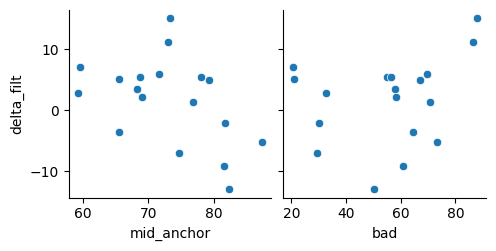

In [652]:
sns.pairplot(g.to_pandas(), x_vars=["mid_anchor", "bad"], y_vars="delta_filt")

In [642]:
g.select("mid_anchor", "delta_filt", "bad").corr()

mid_anchor,delta_filt,bad
f64,f64,f64
1.0,-0.457258,0.38137
-0.457258,1.0,0.264901
0.38137,0.264901,1.0


Nah, that's not a real strong correlation, and I hypothesized a relation in the other direction

### Correlation Likert Ratings and delta_filt?

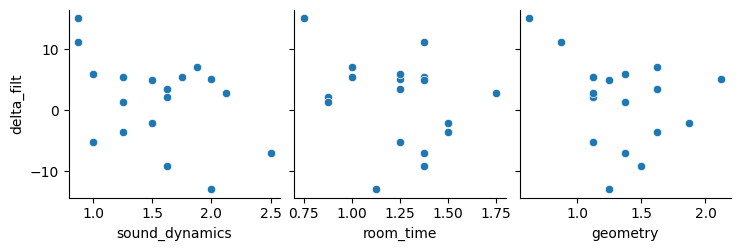

In [647]:
sns.pairplot(
    g.join(df_categories.group_by(
        "trial"
    ).mean().with_columns(
        pl.col("trial").cast(pl.datatypes.UInt32)
    ), on="trial"
      ).to_pandas(),
    x_vars=["timbre_dynamics", "room_time", "geometry"],
    y_vars=["delta_filt"]
)

Nothing significant, it would all be based on outliers. 

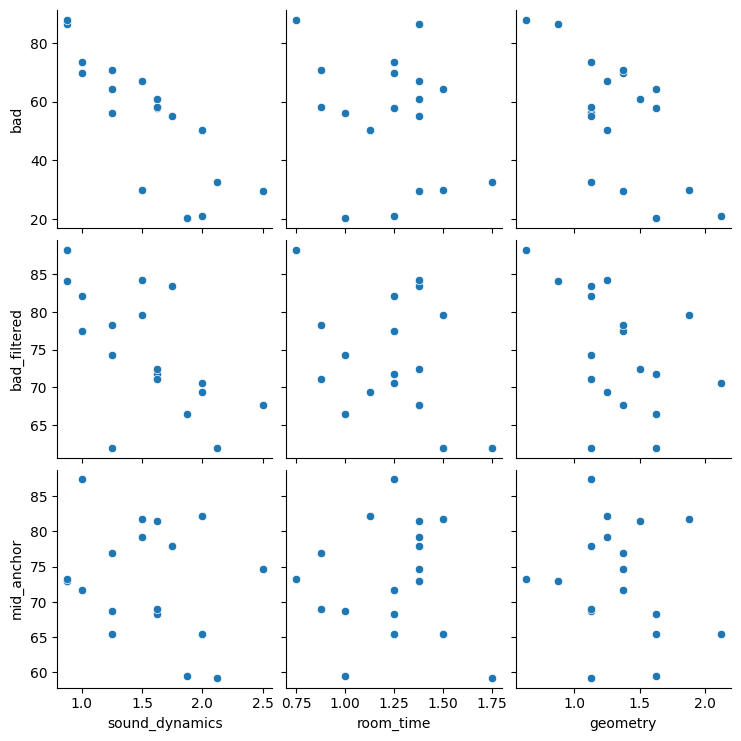

In [653]:
sns.pairplot(
    g.join(df_categories.group_by(
        "trial"
    ).mean().with_columns(
        pl.col("trial").cast(pl.datatypes.UInt32)
    ), on="trial"
      ).to_pandas(),
    x_vars=["timbre_dynamics", "room_time", "geometry"],
    y_vars=["bad", "bad_filtered", "mid_anchor"],
    
)

There is some correlaton between timbre_dynamics and bad/bad_filtered, as well as geometry and bad/bad_filtered. 

The takeaway, non significant probably: Participants identified badness mostly through timbre_dynamics and geometry. room_time did not play a role in MUSHRA ratings. 

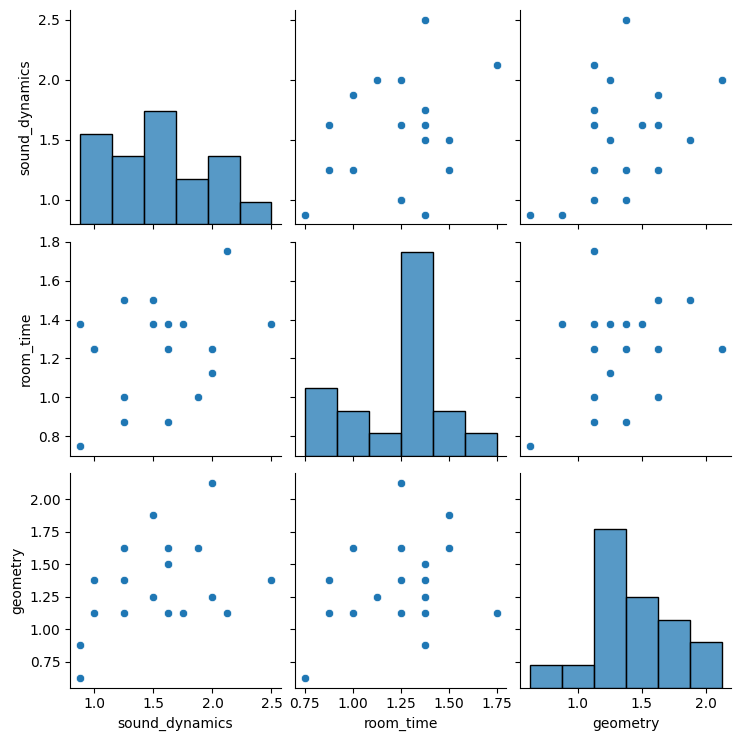

In [654]:
sns.pairplot(
    g.join(df_categories.group_by(
        "trial"
    ).mean().with_columns(
        pl.col("trial").cast(pl.datatypes.UInt32)
    ), on="trial"
      ).to_pandas(),
    x_vars=["timbre_dynamics", "room_time", "geometry"],
    y_vars=["timbre_dynamics", "room_time", "geometry"],
    
)

# Read in Google Forms part

In [23]:
df_forms = pl.read_csv(
    "../src/data/listening_test_forms/Fragebogen zum Hörtest Masterarbeit Johannes Fried.csv"
).filter(
    pl.col("Hörer ID").is_in([0, 6, 10]).not_() # exclude test run, excluded listeners
).select(pl.exclude(
    ["Zeitstempel", "", "_duplicated_0"] # time stamp, checkboxes on DSGVO and webMUSHRA sending
)).rename({
    "Alter": "Age",
    "Weißt du von Beeinträchtigungen deines Gehörs?": "Hearing Impairment",
    "Geschlecht": "Sex",
    "Ich verstehe folgende Sprachen ... [Deutsch]": "German",
    "Ich verstehe folgende Sprachen ... [Englisch]": "English",
    "Ich habe Erfahrungen mit ... [Musik]": "Musical Exp.",
    "Ich habe Erfahrungen mit ... [Audiotechnik]": "Audio Exp.",
    "Ich habe Erfahrungen mit ... [räumlichem Audio]": "Spatial Audio Exp.",
    "Ich habe Erfahrungen mit ... [Hörtests]": "Listening Test Exp.",
}).with_columns(
    pl.col("Hearing Impairment").str.replace("Keine", "None"),
    pl.col("Sex").str.replace("männlich", "male").str.replace("weiblich", "female"),
    pl.col("German", "English").str.replace("sehr gut", 5).str.replace("gut", 4).str.to_integer(),
    pl.col(
        "Musical Exp.","Audio Exp.","Spatial Audio Exp.","Listening Test Exp.",
    ).str.replace(
        "gar keine", 0
    ).str.replace(
        "sehr wenig", 1
    ).str.replace(
        "eher wenig", 2
    ).str.replace(
        "eher mehr", 3
    ).str.replace(
        "sehr viel", 4
    ).str.replace(
        "viel", 5
    ).str.to_integer()
)

Hearing Impairment,Hörer ID,"Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_0","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_0","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_0","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_1","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_1","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_1","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_2","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_2","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_2","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_3","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_3","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_3","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_4","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_4","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_4","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_5","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_5","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_5","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_6","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_6","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_6","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_7","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_7","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_7","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_8","Wenn du nur die zur Referenz mittel ähn

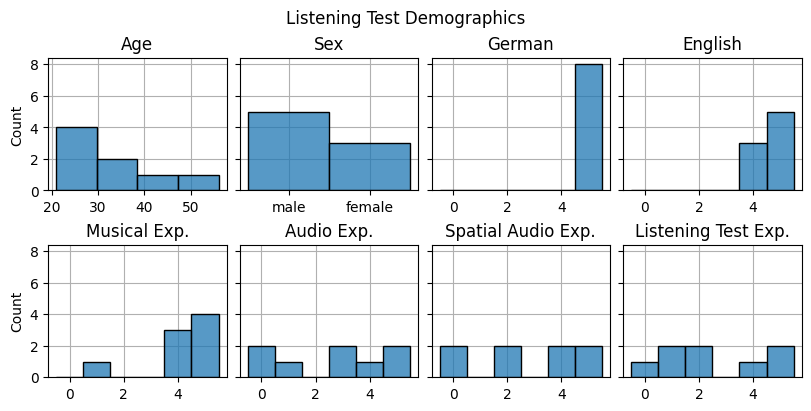

In [24]:
variables = ["Age", "Sex", 
     "German", "English", "Musical Exp.","Audio Exp.",
             "Spatial Audio Exp.","Listening Test Exp.",]
fig, axes = subplots(2, 4, figsize=(8,4), layout="constrained", sharey=True)
axes = axes.flatten()
for i, var in enumerate(variables):
    # plotting all bins doesn't work...
    if var in ["German", "English", "Musical Exp.","Audio Exp.",
             "Spatial Audio Exp.","Listening Test Exp.",]:
        #bins = ["very good", "good", "rather good", "rather bad", "very bad", "not at all"].reverse()
        binrange = (-.5,5.5)
        bins=6
    else:
        binrange = None
        bins="auto"
    sns.histplot(df_forms[var], ax=axes[i], binrange=binrange, bins=bins)
    axes[i].set_title(var)
    #axes[i].tick_params(axis='x', labelrotation=60)
    axes[i].grid(True)
    axes[i].set_axisbelow(True)
    axes[i].set_zorder(0)
suptitle("Listening Test Demographics")
yticks(range(0, 9, 2));
savefig("../reports/figures/listening_test_demographics.pdf")

This is good to have printed :)

# Likert Forms  Analysis

In [25]:
ids = df_forms.sort("Hörer ID")["Hörer ID"].to_numpy()

array([1, 2, 3, 4, 5, 7, 8, 9], dtype=int64)

In [26]:
trials_exp_order = [14, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 12, 15, 16, 17, 18, 19]

[14, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 12, 15, 16, 17, 18, 19]

In [27]:
likert_df = df_forms.sort("Hörer ID").select(
    pl.exclude(["Age", "Sex", 
     "German", "English", "Musical Exp.","Audio Exp.",
             "Spatial Audio Exp.","Listening Test Exp.","Hearing Impairment","Hörer ID"])
)

"Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_0","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_0","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_0","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_1","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_1","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_1","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_2","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_2","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_2","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_3","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_3","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_3","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_4","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_4","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_4","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_5","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_5","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_5","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_6","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_6","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_6","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_7","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Raum und Zeitverhalten]_duplicated_7","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Geometrie]_duplicated_7","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, wie groß waren die Unterschiede in ... [Klangfarbe und Dynamik]_duplicated_8","Wenn du nur die zur Referenz mittel ähnlichen Signale betrachtest, 

In [28]:
# rows are listeners, columns are ratings in order as appeared to the candidate
likert_arr = likert_df.to_numpy()
likert_map = {
    "Unbemerkbar": 0,
    'Bemerkbar aber nicht nervig': 1,
    'Leicht nervig': 2,
    "Nervig": 3,
    "Sehr nervig": 4,
}
likert_map_func = np.vectorize(lambda s: likert_map[s])
likert_num_arr = likert_map_func(likert_arr)
arr = []
for (i,j) in np.ndindex(likert_num_arr.shape):
    if j % 3 != 0:
        continue
    arr.append({
        "ID": ids[i],
        "trial": trials_exp_order[j // 3],
        "timbre_dynamics": likert_num_arr[i,j],
        "room_time": likert_num_arr[i,j+1],
        "geometry": likert_num_arr[i,j+2],
    })
df_categories = pl.DataFrame(arr).filter(
    pl.col("trial").is_in([14,11]).not_()
).with_columns(
    pl.col("trial").cast(pl.datatypes.UInt32)
)

ID,trial,timbre_dynamics,room_time,geometry
i64,u32,i64,i64,i64
1,0,1,0,0
1,1,2,2,1
1,2,1,1,0
1,3,2,1,1
1,4,1,2,1
…,…,…,…,…
9,15,4,3,0
9,16,2,3,2
9,17,1,2,0


In [29]:
144*3

432

In [30]:
df_categories_unpivot = df_categories.melt(
    ["ID", "trial"], ["timbre_dynamics", "room_time", "geometry"]
)

ID,trial,variable,value
i64,u32,str,i64
1,0,"""timbre_dynamic…",1
1,1,"""timbre_dynamic…",2
1,2,"""timbre_dynamic…",1
1,3,"""timbre_dynamic…",2
1,4,"""timbre_dynamic…",1
…,…,…,…
9,15,"""geometry""",0
9,16,"""geometry""",2
9,17,"""geometry""",0


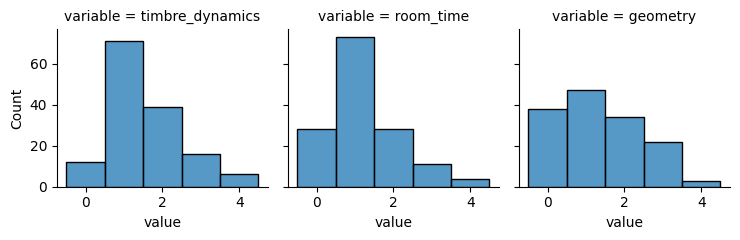

In [51]:
sns.displot(df_categories_unpivot, x="value", col="variable", kind="hist", discrete=True, height=2.5)
#suptitle("Differences")
savefig("../reports/figures/likert_distributions.pdf")

### Unidimensionality

In [785]:
cat_id_arr = np.stack(
    df_categories_unpivot.group_by(
        "trial", "variable", maintain_order=True
    ).agg(
        "value"
    )["value"].to_numpy()
)

array([[1, 1, 1, 1, 2, 0, 0, 1],
       [2, 2, 2, 2, 2, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 0],
       [2, 3, 0, 1, 1, 0, 1, 0],
       [1, 1, 1, 2, 2, 1, 1, 3],
       [2, 1, 1, 1, 1, 1, 1, 2],
       [2, 4, 2, 2, 4, 1, 1, 4],
       [2, 1, 1, 1, 2, 0, 1, 2],
       [2, 3, 2, 2, 2, 1, 1, 3],
       [2, 3, 1, 1, 2, 1, 1, 3],
       [1, 2, 2, 2, 2, 0, 1, 3],
       [2, 3, 1, 2, 1, 1, 1, 2],
       [1, 3, 1, 1, 2, 1, 1, 3],
       [3, 3, 2, 2, 1, 1, 1, 4],
       [1, 0, 1, 1, 2, 0, 1, 2],
       [1, 3, 1, 1, 1, 1, 1, 1],
       [1, 4, 1, 2, 3, 1, 1, 3],
       [2, 2, 2, 1, 3, 0, 1, 4],
       [0, 1, 0, 1, 1, 0, 0, 3],
       [2, 1, 2, 1, 1, 1, 0, 4],
       [1, 1, 1, 1, 1, 1, 1, 4],
       [1, 1, 1, 0, 2, 1, 1, 3],
       [2, 2, 1, 0, 2, 0, 1, 3],
       [0, 1, 0, 0, 1, 1, 1, 3],
       [0, 4, 1, 0, 1, 1, 1, 3],
       [2, 1, 1, 0, 1, 1, 1, 1],
       [0, 2, 1, 0, 1, 1, 1, 3],
       [1, 2, 1, 1, 2, 1, 1, 2],
       [0, 2, 2, 1, 1, 1, 1, 3],
       [0, 0, 2, 2, 2, 1, 1, 2],
       [0,

In [786]:
cat_id_arr.shape

(54, 8)

In [787]:
3*18

54

In [788]:
pca = PCA().fit(cat_id_arr.T) # transpose, because each participant is a sample, each score is a feature

PCA()

Text(0.5, 1.0, 'PCA Explained Variance')

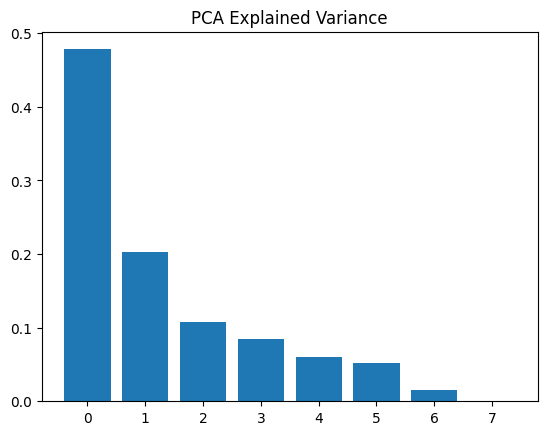

In [789]:
bar(range(8), pca.explained_variance_ratio_)
title("PCA Explained Variance")

In [790]:
pca.explained_variance_ratio_

array([4.78065463e-01, 2.02473353e-01, 1.07830358e-01, 8.44962324e-02,
       5.99098284e-02, 5.17619175e-02, 1.54628471e-02, 6.47961059e-33])

In [791]:
pca.explained_variance_ratio_[0]/pca.explained_variance_ratio_[1]

2.3611278088012466

The scale is a bit less unidimensional than with the MUSHRA, but still not too bad...

### Normal distribution of residuals

In [534]:
mod = ols(
    "value ~ C(ID) + C(trial) + C(variable)",
    df_categories_unpivot.to_pandas()
)

In [535]:
res = mod.fit()

In [536]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     9.424
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           3.24e-28
Time:                        21:58:43   Log-Likelihood:                -511.15
No. Observations:                 432   AIC:                             1076.
Df Residuals:                     405   BIC:                             1186.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4051      0.204      1.986      0.048       0.004       0.806
C(ID)[T.2]                        0.9444      0.157      6.015      0.000       0.636       1.253
C(ID)[T.3]                        0.2963      0.157      1.887      0.060      -0.012       0.605
C(ID)[T.4]                       -0.1481      0.157     -0.943      0.346      -0.457       0.161
C(ID)[T.5]                        0.7222      0.157      4.599      0.000       0.414       1.031
C(ID)[T.7]                       -0.3889      0.157     -2.477      0.014      -0.698      -0.080
C(ID)[T.8]                       -0.1111      0.157     -0.708      0.480      -0.420       0.198
C(ID)[T.9]                        1.2037      0.157      7.666      0.000       0.895       1.512
C(trial)[T.1]                     0.8750      0.236      3.715      0.000       0.412       1.338
C(trial)[T.2]                     0.2917      0.236      1.238      0.216      -0.171       0.755
C(trial)[T.3]                     0.3750      0.236      1.592      0.112      -0.088       0.838
C(trial)[T.4]                     0.6250      0.236      2.654      0.008       0.162       1.088
C(trial)[T.5]                     0.4167      0.236      1.769      0.078      -0.046       0.880
C(trial)[T.6]                     1.0000      0.236      4.246      0.000       0.537       1.463
C(trial)[T.7]                     0.3750      0.236      1.592      0.112      -0.088       0.838
C(trial)[T.8]                     0.7083      0.236      3.007      0.003       0.245       1.171
C(trial)[T.9]                     0.6667      0.236      2.830      0.005       0.204       1.130
C(trial)[T.10]                    0.7500      0.236      3.184      0.002       0.287       1.213
C(trial)[T.12]                    0.4583      0.236      1.946      0.052      -0.005       0.921
C(trial)[T.13]                    0.7500      0.236      3.184      0.002       0.287       1.213
C(trial)[T.15]                    0.9167      0.236      3.892      0.000       0.454       1.380
C(trial)[T.16]                    0.4583      0.236      1.946      0.052      -0.005       0.921
C(trial)[T.17]                    0.7083      0.236      3.007      0.003       0.245       1.171
C(trial)[T.18]                    1.0417      0.236      4.423      0.000       0.579       1.505
C(trial)[T.19]                    0.7500      0.236      3.184      0.002       0.287       1.213
C(variable)[T.room_time]         -0.1042      0.096     -1.083      0.279      -0.293       0.085
C(variable)[T.sound_dynamics]     0.1944      0.096      2.022      0.044       0.005       0.383
==============================================================================
Omnibus:                        5.060   Durbin-Watson:          

Both Jarque-Bera as well as Omnibus indicate somewhat normal residuals, with a probability of 8 %.  

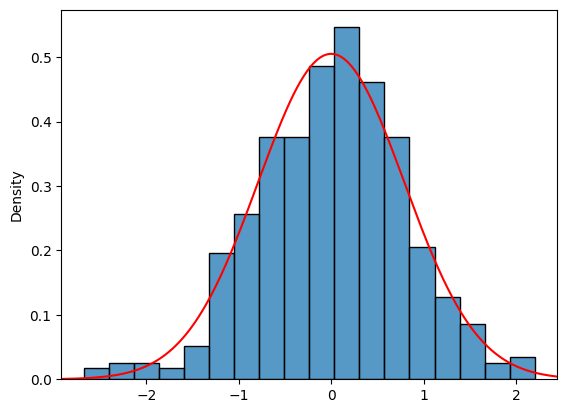

In [537]:
sns.histplot(res.resid, stat="density")
autoscale(False)
xh = np.linspace(*gca().get_xlim(), 300)
plot(xh, scipy.stats.norm.pdf(xh, loc=np.mean(res.resid), scale=np.std(res.resid)), "red")

# rmANOVA

In [539]:
anovarm = AnovaRM(df_categories_unpivot.to_pandas(), "value", "ID", within=["trial", "variable"]).fit()

In [540]:
anovarm.anova_table

,F Value,Num DF,Den DF,Pr > F
trial,2.802942,17.0,119.0,0.000568
variable,1.496783,2.0,14.0,0.257576
trial:variable,1.254125,34.0,238.0,0.168363


In [541]:
anovarm.summary()

,F Value,Num DF,Den DF,Pr > F
trial,2.8029,17.0000,119.0000,0.0006
variable,1.4968,2.0000,14.0000,0.2576
trial:variable,1.2541,34.0000,238.0000,0.1684


Unfortunately no significant interaction trial:variable...

### Post-hoc Tukey HSD

In [542]:
hsd = pairwise_tukeyhsd(df_categories_unpivot["value"], df_categories_unpivot["trial"])

In [543]:
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.875,0.1719,-0.1247,1.8747,False
0,2,0.2917,0.9999,-0.708,1.2914,False
0,3,0.375,0.9978,-0.6247,1.3747,False
0,4,0.625,0.7559,-0.3747,1.6247,False
0,5,0.4167,0.9926,-0.583,1.4164,False
0,6,1.0,0.0498,0.0003,1.9997,True
0,7,0.375,0.9978,-0.6247,1.3747,False
0,8,0.7083,0.5411,-0.2914,1.708,False
0,9,0.6667,0.6525,-0.333,1.6664,False
0,10,0.75,0.4309,-0.2497,1.7497,False


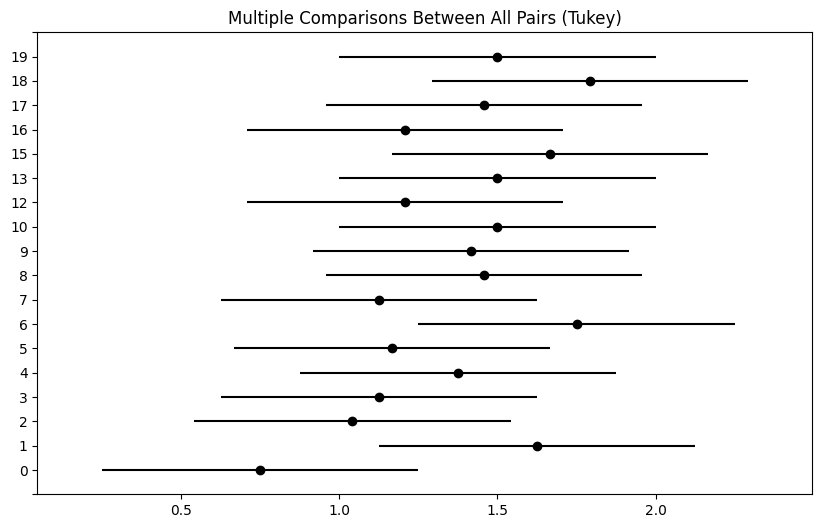

In [544]:
hsd.plot_simultaneous();

Not many significant differences, training effect with rising differences visible. 

Significant for 0-6, 0-18. 

### Manual plot for trial:variable

In [545]:
df_categories

ID,trial,sound_dynamics,room_time,geometry
i64,i64,i64,i64,i64
1,0,1,0,0
1,1,2,2,1
1,2,1,1,0
1,3,2,1,1
1,4,1,2,1
…,…,…,…,…
9,15,4,3,0
9,16,2,3,2
9,17,1,2,0


<Axes: xlabel='trial', ylabel='value'>

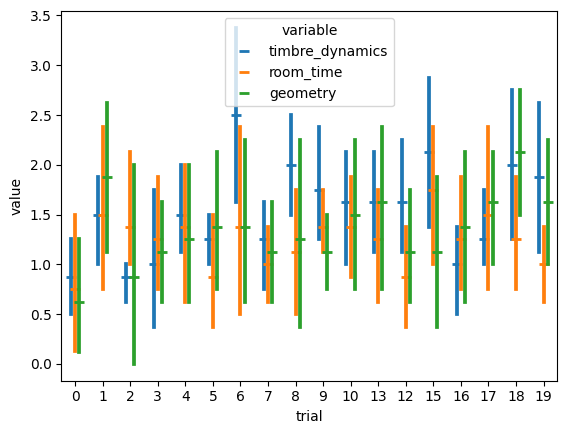

In [805]:
sns.pointplot(df_categories_unpivot, 
              x="trial", y="value", hue="variable", 
              linestyle="none", order=trials_exp_order[2:], 
              capsize=0, dodge=.3, marker="_")

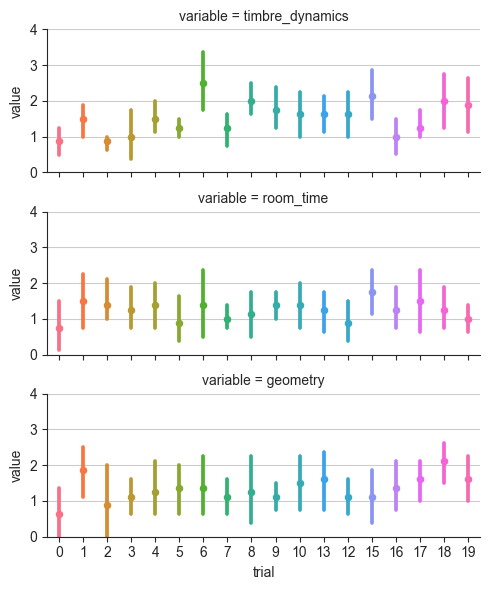

In [837]:
sns_grid = sns.FacetGrid(df_categories_unpivot,  row="variable", hue="trial", aspect=2.5, height=2)
sns.set_style("ticks",{'axes.grid' : True})
sns_grid.map(sns.pointplot, "trial", "value",
              linestyle="none", order=trials_exp_order[2:], 
              capsize=0, marker="."
            )
ylim(0, 4)
savefig("../reports/figures/categories_trials.pdf")

Text(0, 0.5, 'Mean Likert Difference Score')

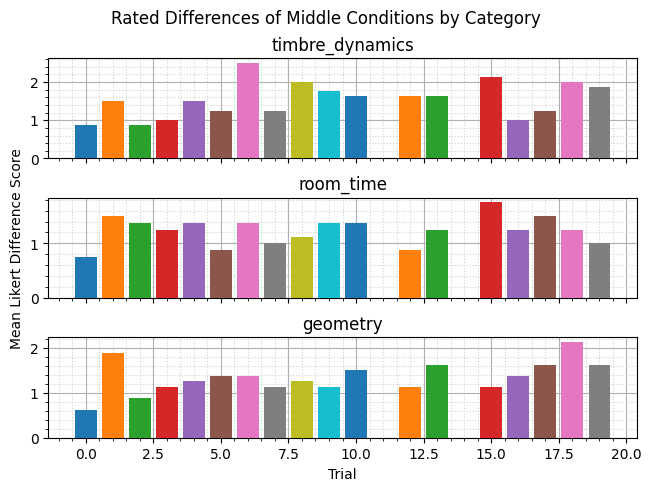

In [792]:
fig, axes = subplots(3,1, sharex=True, layout="constrained")
for trial in df_categories["trial"].unique():
    means = df_categories.filter(
        pl.col("trial").eq(trial)
    ).mean()
    axes[0].bar(trial, means["timbre_dynamics"], zorder=3)
    axes[1].bar(trial, means["room_time"], zorder=3)
    axes[2].bar(trial, means["geometry"], zorder=3)
for i in range(3):
    axes[i].grid(True, which="major")
    axes[i].grid(True, which="minor", color="lightgrey", linestyle=":")
    axes[i].minorticks_on()
axes[0].set_title("timbre_dynamics")
axes[1].set_title("room_time")
axes[2].set_title("geometry")
xlabel("Trial")
suptitle("Rated Differences of Middle Conditions by Category")
axes[1].set_ylabel("Mean Likert Difference Score")

Personal Listening Comments for extreme cases:
- 1: very strong localization shift, source change behind wall is not supported by algorithm
- 18: (one of two worst rated trials) actually I don't notice a strong difference in localization, but a muffled sound and much larger apparent source width, not sure why
- 15: (one of two worst rated trials) very strong change in reverb, yes!
- 3: (best rated trial) actually clear spectral and localizaiton difference
- 6: telephone sound in bad condition

In [594]:
design.filter(
    # high geometry errors
    pl.col("index").is_in([1, 18])
)

index,to_listener,to_source,room,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3
18,"""-1.25X_0.0Y""",4,"""HL05W""","""3.0X_2.0Y""",3


Wow, that is crazy: An HL05W one...

In [596]:
design.filter(
    # low geometry errors
    pl.col("index").is_in([0, 3])
)

index,to_listener,to_source,room,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32
0,"""0.0X_0.0Y""",1,"""HL05W""","""3.0X_2.0Y""",1
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",3


In [599]:
design.filter(
    # high room_time errors
    pl.col("index").is_in([1, 15])
)

index,to_listener,to_source,room,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3
15,"""-1.25X_0.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4


In [598]:
design.filter(
    # low room_time errors
    pl.col("index").is_in([0, 5])
)

index,to_listener,to_source,room,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32
0,"""0.0X_0.0Y""",1,"""HL05W""","""3.0X_2.0Y""",1
5,"""3.0X_2.0Y""",1,"""HL05W""","""3.0X_2.0Y""",3


This seems associated with room!

In [600]:
design.filter(
    # high timbre_dynamics errors
    pl.col("index").is_in([6, 15])
)

index,to_listener,to_source,room,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32
6,"""-1.75X_-3.0Y""",4,"""HL06W""","""0.0X_0.0Y""",2
15,"""-1.25X_0.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4


In [601]:
design.filter(
    # low timbre_dynamics errors
    pl.col("index").is_in([0, 2,16])
)

index,to_listener,to_source,room,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32
0,"""0.0X_0.0Y""",1,"""HL05W""","""3.0X_2.0Y""",1
2,"""1.75X_-2.0Y""",2,"""HL05W""","""3.0X_2.0Y""",1
16,"""1.75X_-2.0Y""",2,"""HL06W""","""0.0X_0.0Y""",4


# Likert Scales - Room Assocations

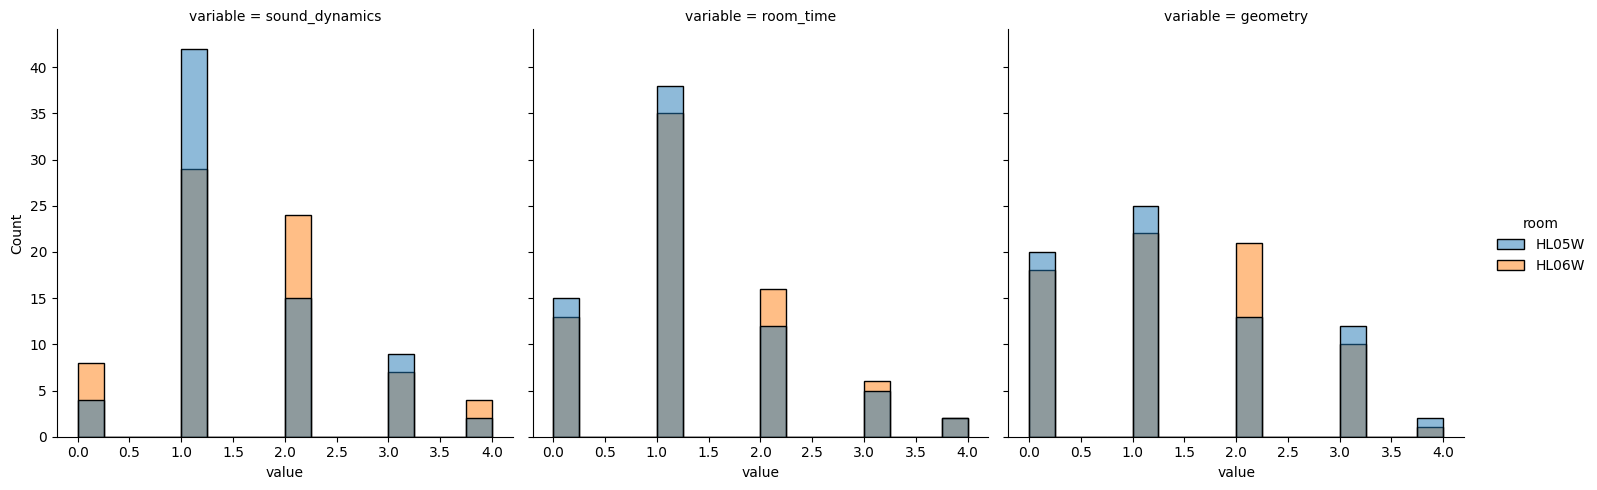

In [611]:
df_categories_unpivot_joined = df_categories_unpivot.with_columns(
    trial = pl.col("trial").cast(pl.datatypes.UInt32)
).join(
    design, left_on="trial", right_on="index"
)
sns.displot(df_categories_unpivot_joined, x="value", col="variable", kind="hist", hue="room")

In [617]:
hsd = pairwise_tukeyhsd(df_categories_unpivot_joined.filter(pl.col("variable").eq("room_time"))["value"], 
                        df_categories_unpivot_joined.filter(pl.col("variable").eq("room_time"))["room"])

In [618]:
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
HL05W,HL06W,0.1111,0.4829,-0.2011,0.4233,False


# Likert Scale vs MUSHRA Ratings

In [53]:
df_cat_mushra_pairplot = df_categories_unpivot.join(
    df_trial.select("*"), on=["trial", "ID"]
).pivot(
    values=["rating_score"], index=["ID", "trial", "variable", "value"], columns=["rating_stimulus", ]
).pivot(
    values=["value"], index=["ID", "trial", "bad_filtered", "bad", "lower_anchor", "mid_anchor", "reference"], columns=["variable"]
)

ID,trial,bad_filtered,bad,lower_anchor,mid_anchor,reference,timbre_dynamics,room_time,geometry
i64,u32,i64,i64,i64,i64,i64,i64,i64,i64
1,0,90,95,0,71,100,1,0,0
1,1,67,0,37,83,100,2,2,1
1,2,75,89,0,45,100,1,1,0
1,3,86,72,49,81,100,2,1,1
1,4,68,50,0,82,100,1,2,1
…,…,…,…,…,…,…,…,…,…
9,15,75,21,45,75,100,4,3,0
9,16,95,60,53,71,100,2,3,2
9,17,78,78,59,74,100,1,2,0


In [54]:
18*8

144

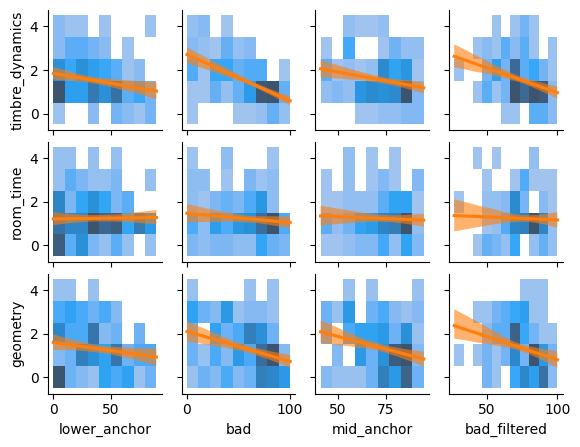

In [61]:
gr = sns.pairplot(
    df_cat_mushra_pairplot.to_pandas(),
    x_vars=["lower_anchor", "bad", "mid_anchor", "bad_filtered"],
    y_vars=["timbre_dynamics", "room_time", "geometry"],
    kind="reg", markers="+", plot_kws={"scatter":False, "color": "C1"},
    height=1.5,
)
for a in gr.axes.reshape(-1):
    setp(a.collections, alpha=.6)
gr.map(sns.histplot, discrete=(False, True), zorder=.6)
savefig("../reports/figures/mushra_category_correlations.pdf")

In [903]:
df_cat_mushra_pairplot.write_parquet("listening_test_ratings.parquet")